In [70]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits

from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [71]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../HERA_MapMaking_VisibilitySimulation/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [72]:
len(sys.argv)

3

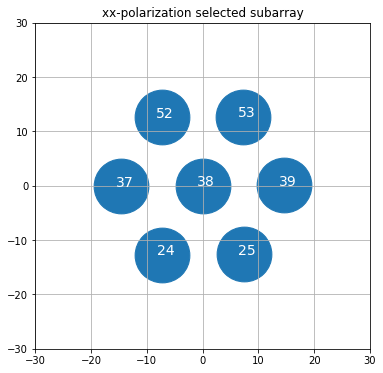

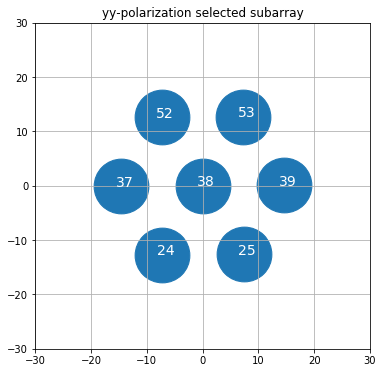

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [73]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = True # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Add_S_diag = False
	Add_Rcond = True
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_max8I' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data
	rcond_list = 10.**np.arange(-7., -0., 1.)
    
	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mant = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(omnical.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

In [74]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
2


In [75]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

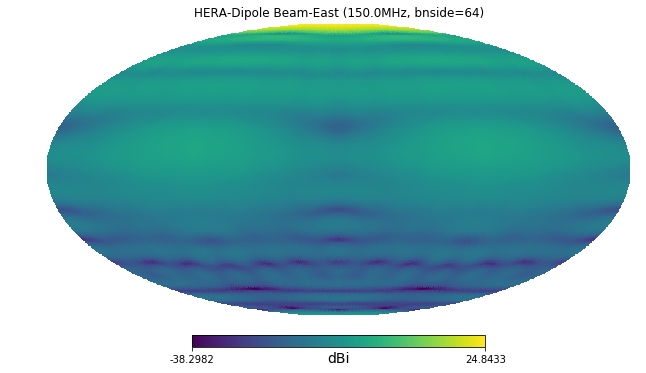

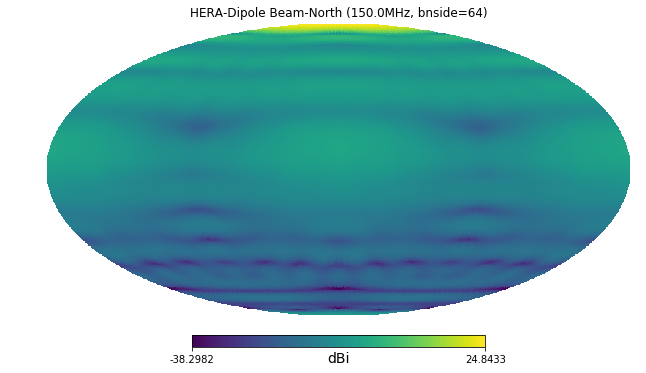

In [76]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [77]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


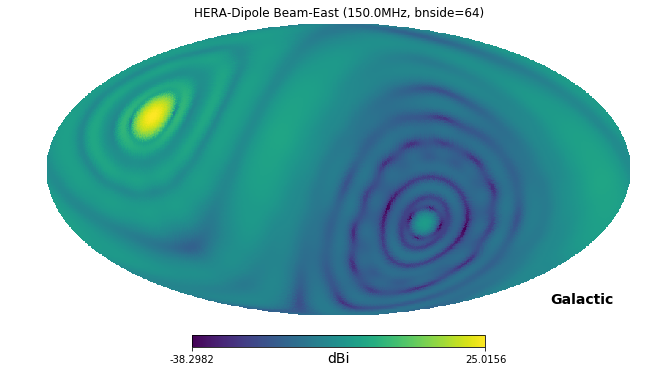

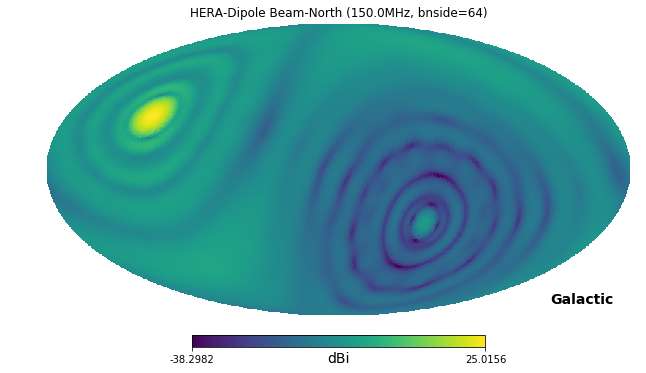

In [78]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


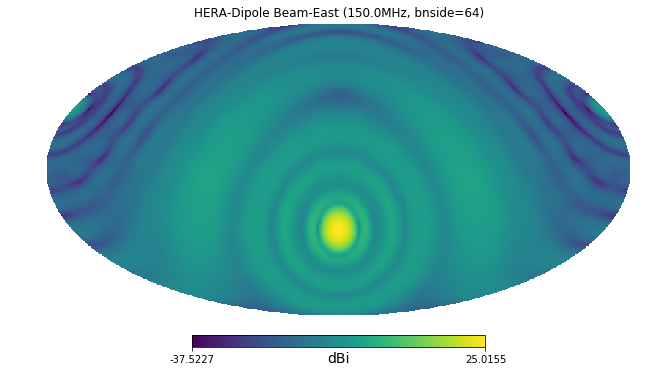

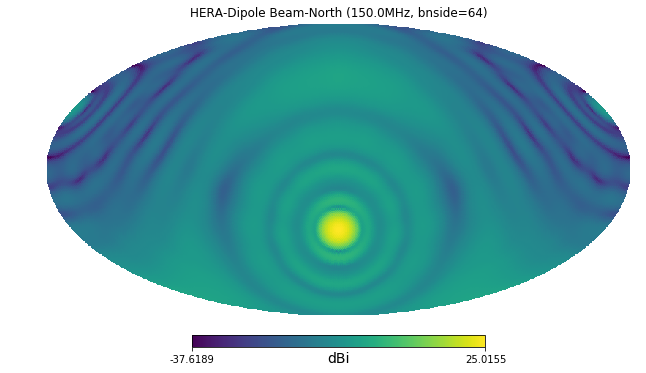

In [79]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

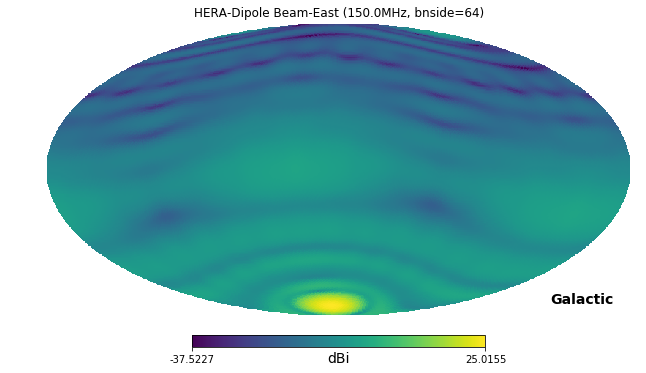

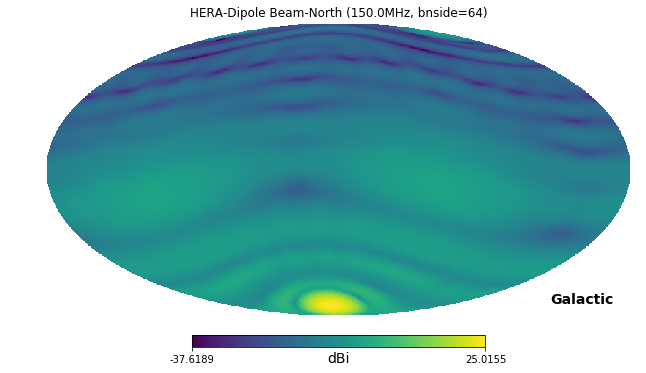

In [80]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [81]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [82]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [83]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [84]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [85]:
#print A.shape

In [86]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [87]:
print autocorr_vis.mean()
print fullsim_vis.mean()

1227565.6587779154
(1556.6106039729052-329.7816353772341j)


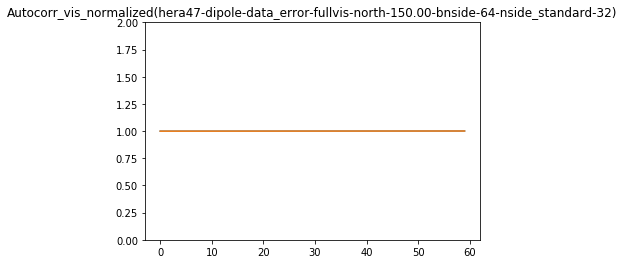

In [88]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [89]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [90]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [91]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25


In [92]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


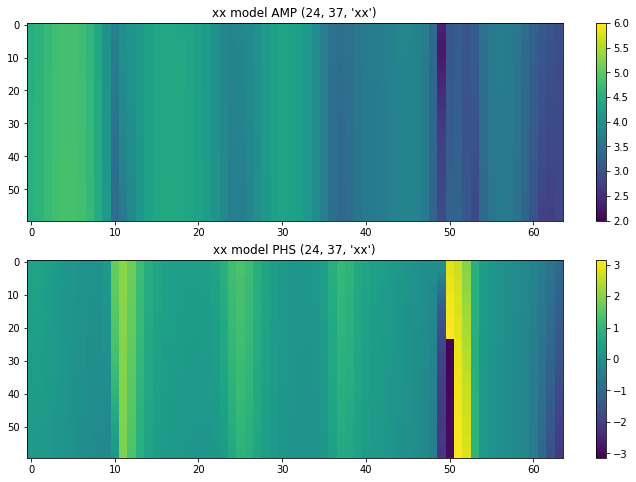

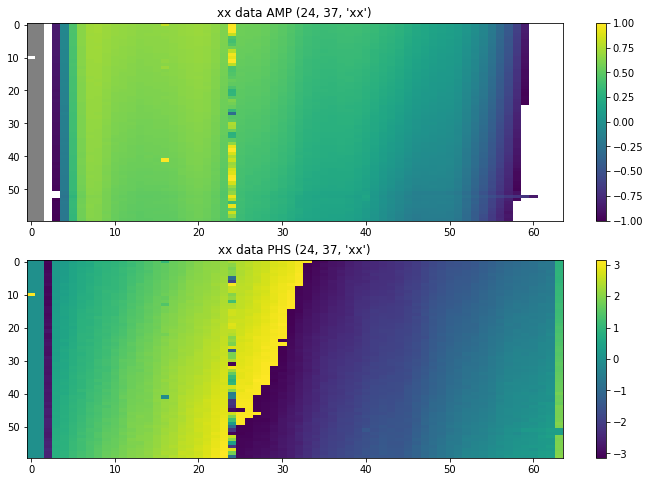

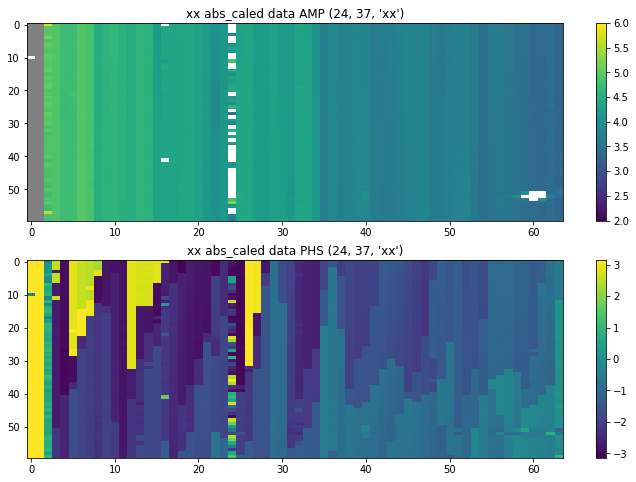

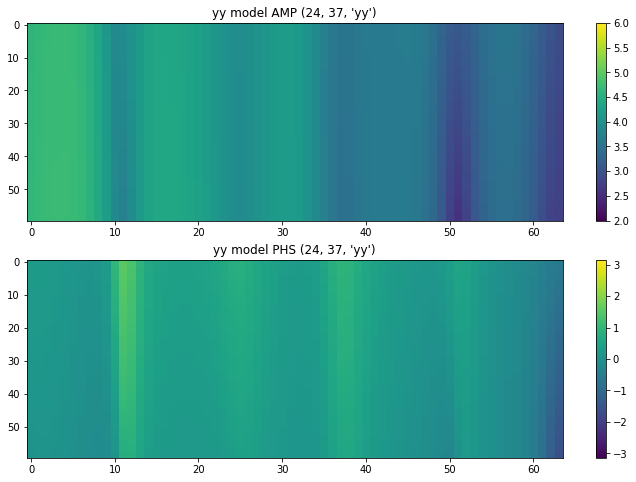

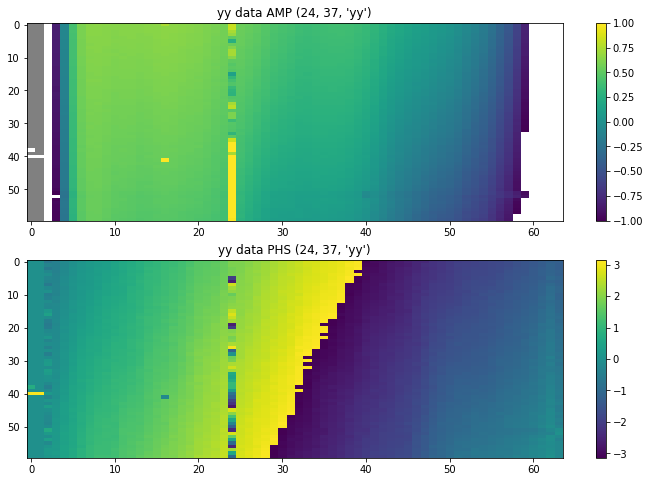

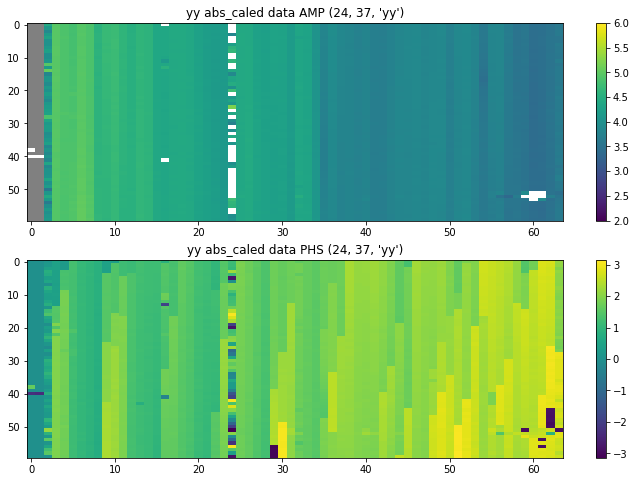

In [93]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [94]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [95]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [96]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		cal_lst_range = np.array([5, 6]) / TPI * 24.
		calibrate_ubl_length = 1600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		#cal_ubl_mask = {}
		
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		cal_sources = ['cyg', 'cas']
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-08 17:42:12.108381, expected time 0.0 min 6 UBLs to include
6 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.00015523 0.00023189] [-0.00312171 -0.00366227] 0.8289574956431206
2 [0.00031045 0.00046378] [-0.00619486 -0.00723759] 0.8289580017533664
3 [0.00046568 0.00069567] [-0.00922154 -0.0107295 ] 0.8289588039021899
4 [0.00062091 0.00092755] [-0.01220183 -0.01413791] 0.8289598230903166
5 [0.00077614 0.00115944] [-0.01513378 -0.01745905] 0.8289609710379191
6 [0.00093136 0.00139133] [-0.018013   -0.02073775] 0.8289621574434257
7 [0.00108659 0.00162322] [-0.02083165 -0.02390599] 0.828963308064934
8 [0.00124182 0.00185511] [-0.02357789 -0.0269411 ] 0.8289643348990337
9 [0.00139704 0.002087  ] [-0.02623286 -0.02980645] 0.828965178915511
10 [0.00155227 0.00231889] [-0.02876597 -0.0324404 ] 0.8289658030484162
11 [0.0017075  0.00255077] [-0.03112613 -0.03473008] 0.828966196041966
12 [0.00186273 0.00278266] [-0.03325757 -0.03644563] 0.8

19 [-0.01073211 -0.01045365] [0.00023911 0.02038574] 2.1693592310725442
20 [-0.01129696 -0.01100384] [0.00014314 0.02144202] 2.1693681268604696
21 [-0.01186181 -0.01155403] [3.07206907e-05 2.24959210e-02] 2.169376666033152
22 [-0.01242665 -0.01210422] [-9.95319501e-05  2.35472172e-02] 2.169384828281731
23 [-0.0129915  -0.01265442] [-0.00024917  0.02459566] 2.1693925954183144
24 [-0.01355635 -0.01320461] [-0.00041997  0.02564096] 2.1693999515277875
25 [-0.0141212 -0.0137548] [-0.00061392  0.02668277] 2.1694068830683624
26 [-0.01468605 -0.01430499] [-0.00083331  0.02772069] 2.169413378991004
27 [-0.01525089 -0.01485518] [-0.00108072  0.02875421] 2.1694194309671078
28 [-0.01581574 -0.01540538] [-0.00135911  0.02978275] 2.1694250332809735
29 [-0.01638059 -0.01595557] [-0.00167184  0.03080562] 2.1694301830371145
30 [-0.01694544 -0.01650576] [-0.00202269  0.03182197] 2.169434880524494
31 [-0.01751029 -0.01705595] [-0.00241593  0.03283084] 2.1694391292480195
32 [-0.01807513 -0.01760614] [-0.0

31 [-0.00637067 -0.1390974 ] [-0.02399666 -0.0055792 ] 63.808127553711365
32 [-0.17242679 -0.3142493 ] [-0.01960923 -0.00087841] 63.73431172414701
33 [ 0.00221684 -0.13470367] [-0.02486592 -0.00587316] 63.804272225326386
34 [-0.16325252 -0.31102648] [-0.02068373 -0.00178798] 63.72843858950041
35 [ 0.00865337 -0.13205762] [-0.02566066 -0.00620638] 63.80098471337306
36 [-0.15555329 -0.30856878] [-0.0212894 -0.00179  ] 63.73098537979309
37 [ 0.01436701 -0.130221  ] [-0.02607339 -0.0062445 ] 63.799266382962706
38 [-0.14982001 -0.30726021] [-0.02152457 -0.00147538] 63.7389929348327
39 [ 0.0183561  -0.12881327] [-0.02625994 -0.00612621] 63.79957053960581
40 [-0.14576421 -0.3061692 ] [-0.0215945  -0.00136602] 63.74309611758646
41 [-0.16285192 -0.23469071] [-0.02630961 -0.00609292] 63.7996082034887
42 [-0.15616551 -0.26196963] [-0.01155825  0.00707256] 63.83236532367108
43 [ 0.02366661 -0.12053642] [-0.01799373  0.00064209] 63.814043499742034
44 [-0.14101994 -0.30324053] [-0.01338758  0.003685

45 [0.22354481 0.22216549] [0.01223318 0.08679953] 18476.476855428762
46 [0.22377838 0.22534785] [0.01235452 0.08699409] 18475.338479788737
47 [0.22399589 0.22886274] [0.01246145 0.08717706] 18474.803471696585
48 [0.22424223 0.23278693] [0.01255358 0.08735135] 18474.532714989917
49 [0.22458515 0.23718918] [0.01262334 0.08751981] 18474.369191709517
50 [0.22516572 0.24192372] [0.0126809  0.08767595] 18474.163169716972
51 [0.22598584 0.24739211] [0.01272928 0.08782396] 18473.413616558802
52 [0.22684583 0.25298645] [0.01277404 0.08796175] 18472.20964614726
53 [0.22772246 0.25870268] [0.01282505 0.08808613] 18470.721269602833
54 [0.22846352 0.26429062] [0.01287225 0.0882022 ] 18468.79632640982
55 [0.22933688 0.26946542] [0.01291627 0.08830109] 18466.552682813875
56 [0.23008633 0.27420791] [0.01295705 0.08839507] 18463.97727251298
57 [0.23061169 0.27878546] [0.01299602 0.08848122] 18461.239140170546
58 [0.23095119 0.28326629] [0.01303502 0.08854312] 18458.03715422714
59 [0.23119863 0.2875724

61 [-0.02394691 -0.05260079] [0.04836453 0.01798684] 31212.585905588265
62 [-0.02417678 -0.0532544 ] [0.048559   0.01823793] 31264.358773493175
63 [-0.0244018 -0.0539053] [0.04874636 0.01848407] 31315.120067917855
64 [-0.02462204 -0.05455346] [0.04892691 0.01872527] 31364.9223244709
65 [-0.02483673 -0.05519885] [0.04910439 0.01896336] 31413.78413383197
66 [-0.02504602 -0.05584144] [0.04927957 0.01919797] 31461.902304154515
67 [-0.02525007 -0.0564812 ] [0.04945217 0.0194291 ] 31509.358229520367
68 [-0.02545085 -0.05712127] [0.04962053 0.01965678] 31556.136905898904
69 [-0.02564867 -0.05776203] [0.04978476 0.01988099] 31602.364710844726
70 [-0.02584359 -0.05840348] [0.04994499 0.02010174] 31648.086393178663
71 [-0.02603646 -0.05904565] [0.05010133 0.02031901] 31693.3147399349
72 [-0.02622496 -0.05968445] [0.05025388 0.02053278] 31738.13310680437
73 [-0.02640875 -0.0603191 ] [0.05040274 0.02074308] 31782.21537726784
74 [-0.02658791 -0.06094962] [0.05054684 0.0209499 ] 31825.510846613248
7

73 [-0.04318246 -0.04641467] [0.01202446 0.18660361] 103381.28298082757
74 [-0.0438775  -0.04705523] [0.01223213 0.18593735] 103060.52884841299
75 [-0.04457572 -0.04769264] [0.012439   0.18527238] 102732.21560874666
76 [-0.04527719 -0.04832696] [0.01264506 0.18460869] 102396.2310446643
77 [-0.04598195 -0.0489582 ] [0.01285032 0.18394629] 102052.46475826262
78 [-0.04669007 -0.0495864 ] [0.01305478 0.18328518] 101700.80832245493
79 [-0.04740161 -0.0502116 ] [0.01325845 0.18262537] 101341.15622288296
80 [-0.04811663 -0.05083383] [0.01346134 0.18196684] 100973.40552135199
81 [-0.04883567 -0.05145285] [0.01366352 0.18130965] 100597.45648771904
82 [-0.04956113 -0.05206735] [0.01386546 0.18065407] 100212.48200242606
83 [-0.05029311 -0.05267736] [0.01406717 0.1800001 ] 99814.76962133573
84 [-0.05103168 -0.05328298] [0.01426869 0.17934778] 99404.09950364781
85 [-0.05177692 -0.05388424] [0.01447003 0.17869711] 98980.33008892361
86 [-0.05252893 -0.05448117] [0.01467122 0.17804811] 98543.261359775

85 [-0.01341405 -0.01743337] [-0.10219368  0.0734013 ] 55370.108814734915
86 [-0.01344434 -0.0174775 ] [-0.10214873  0.07351932] 55371.2912360978
87 [-0.01347364 -0.01751992] [-0.10210699  0.07363141] 55372.41165621223
88 [-0.01350211 -0.01756097] [-0.10206815  0.07373782] 55373.47578999273
89 [-0.01352978 -0.0176007 ] [-0.10202758  0.07384133] 55374.4892500327
90 [-0.01355668 -0.01763916] [-0.1019851   0.07394243] 55375.52542595385
91 [-0.01358287 -0.01767643] [-0.10194186  0.07404123] 55376.58730674714
92 [-0.01360849 -0.0177128 ] [-0.10189956  0.07413695] 55377.65580746194
93 [-0.01363357 -0.01774829] [-0.10185767  0.07422998] 55378.70466078743
94 [-0.01365814 -0.01778295] [-0.10181625  0.07432039] 55379.742350880886
95 [-0.0136822  -0.01781681] [-0.10177539  0.07440826] 55380.76768029123
96 [-0.01370578 -0.0178499 ] [-0.10173513  0.07449363] 55381.77970198413
97 [-0.0137289  -0.01788225] [-0.10169551  0.07457658] 55382.777662420085
98 [-0.01375158 -0.01791388] [-0.10165657  0.07465

96 [ 0.27159444 -0.105075  ] [-0.33593251  0.26758033] 54946.33329468835
97 [ 0.27182431 -0.10392232] [-0.33820277  0.26701833] 54781.39639090432
98 [ 0.27210074 -0.10287996] [-0.34026071  0.26638683] 54657.26492455815
99 [ 0.27237232 -0.1019297 ] [-0.34218771  0.26567573] 54552.65095969046
100 [ 0.27262874 -0.10106768] [-0.34401953  0.26490952] 54454.697807328994
((382.11092758415816+0j), 110.9375, array([ 0.27262874, -0.10106768]), 110.9375, array([-0.34401953,  0.26490952]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00342895 -0.00229041] [0.00291742 0.00289777] 86093.35022972249
2 [ 0.0067954  -0.00460564] [0.00552866 0.00578411] 85989.60088221954
3 [ 0.01010478 -0.00695503] [0.00798972 0.00861967] 85987.26424736583
4 [ 0.01335561 -0.0093452 ] [0.0103953  0.01141217] 86075.4912477657
5 [ 0.01654989 -0.01177307] [0.0127549  0.01416187] 86245.19742107301
6 [ 0.01968089 -0.01424908] [0.01518454 0.0168061 ] 86487.24516289505
7 [ 0.022745   -

7 [-0.01332355  0.00860333] [ 0.01070908 -0.00809638] 36486.543086248486
8 [-0.01472595  0.00971582] [ 0.0115051  -0.00875695] 36419.89967510112
9 [-0.01603462  0.01080569] [ 0.01217587 -0.00933389] 36370.025839662274
10 [-0.01726506  0.01188968] [ 0.01274506 -0.00984638] 36333.74207438236
11 [-0.01841189  0.01295122] [ 0.01322869 -0.01030496] 36308.06162934767
12 [-0.01947367  0.01398377] [ 0.01363988 -0.01071826] 36290.56738032602
13 [-0.02055365  0.01505679] [ 0.01398524 -0.01108604] 36279.41133758605
14 [-0.0215465   0.01609964] [ 0.01427495 -0.01141506] 36275.50588162315
15 [-0.02245703  0.01711486] [ 0.0145195  -0.01171448] 36275.90366019943
16 [-0.02329352  0.01811069] [ 0.01472517 -0.01198809] 36279.43933237701
17 [-0.02406118  0.01909159] [ 0.01489738 -0.01223915] 36285.57070768602
18 [-0.02476674  0.02006507] [ 0.01503907 -0.01246756] 36293.81270596438
19 [-0.02541813  0.02104163] [ 0.01515521 -0.01267707] 36304.03340567557
20 [-0.02601774  0.02202321] [ 0.01524927 -0.0128696

17 [-0.08461571 -0.05387132] [-0.02270793 -0.01268986] 35712.584953271624
18 [-0.08618014 -0.05625254] [-0.02317983 -0.01354589] 35717.40620923776
19 [-0.08747332 -0.05859818] [-0.02367306 -0.01437778] 35725.04144732697
20 [-0.08860326 -0.06082701] [-0.02414555 -0.01518132] 35732.90016448597
21 [-0.08959869 -0.06294389] [-0.02459214 -0.01597474] 35741.55242799798
22 [-0.09047418 -0.06495406] [-0.02501868 -0.01675498] 35750.42464503782
23 [-0.09132986 -0.06694771] [-0.02543237 -0.01751343] 35759.38386329275
24 [-0.09203676 -0.06892858] [-0.02583382 -0.01824965] 35770.34873579889
25 [-0.09268112 -0.07080622] [-0.02622345 -0.0189636 ] 35781.44262063657
26 [-0.09327545 -0.07258847] [-0.02660252 -0.01965558] 35792.84052924108
27 [-0.0938226  -0.07428803] [-0.02696574 -0.02033862] 35804.48329777568
28 [-0.09428432 -0.07598855] [-0.02731983 -0.02100884] 35816.02747791739
29 [-0.0947252  -0.07761018] [-0.02766617 -0.02166456] 35827.81479723455
30 [-0.09514504 -0.07916667] [-0.02800532 -0.02230

31 [-0.07647588  0.02575372] [0.02740123 0.05559201] 32868.128855079674
32 [-0.0767497   0.02575007] [0.0317312  0.05405618] 32927.90937163541
33 [-0.07699195  0.02572074] [0.03645754 0.05242076] 33021.26505405572
34 [-0.07720628  0.02565734] [0.04167873 0.05068103] 33156.100004337946
35 [-0.07739679  0.02554784] [0.04746627 0.04891289] 33336.97375403986
36 [-0.07756101  0.02537025] [0.05389652 0.04711747] 33563.174781563925
37 [-0.07769895  0.02509496] [0.06107108 0.04511637] 33828.46334574359
38 [-0.07786819  0.02471508] [0.06934615 0.0427472 ] 34122.66894359454
39 [-0.07799983  0.02412826] [0.07944807 0.03953693] 34434.27290352128
40 [-0.07823343  0.02335245] [0.09174913 0.03565582] 34739.21228892142
41 [-0.07759213  0.02088156] [0.1059237  0.03024728] 34964.44021895734
42 [-0.06497574 -0.00138376] [-0.07730983 -0.12019857] 35043.98125001032
43 [-0.06628728 -0.00047916] [-0.07550606 -0.11935953] 29741.673832897774
44 [-0.06755118  0.00037648] [-0.07377914 -0.118545  ] 29820.55557206

43 [-0.11779494 -0.01018387] [0.01311678 0.14646366] 40027.05002174517
44 [-0.11791525 -0.01051292] [0.01322785 0.146969  ] 40041.63534019559
45 [-0.11802625 -0.01084264] [0.01332905 0.14742984] 40054.29754909313
46 [-0.11812969 -0.01117266] [0.01342247 0.14785118] 40065.28395614931
47 [-0.11822699 -0.0115027 ] [0.01350819 0.1482368 ] 40074.835584602224
48 [-0.11831933 -0.01183251] [0.01358677 0.14859009] 40083.05765699506
49 [-0.11840764 -0.01216189] [0.01360568 0.14894454] 40090.068830073746
50 [-0.11849292 -0.01249065] [0.01360392 0.14929035] 40094.01674180696
51 [-0.1185758  -0.01281867] [0.01363168 0.14960345] 40096.68152927758
52 [-0.11865658 -0.0131459 ] [0.01367114 0.14988796] 40100.05517733339
53 [-0.11873567 -0.01347241] [0.01371448 0.15014754] 40103.308797778736
54 [-0.11881346 -0.01379827] [0.01375778 0.15038506] 40106.12487112685
55 [-0.11889012 -0.0141233 ] [0.01377516 0.1506166 ] 40108.370056934284
56 [-0.11896579 -0.0144471 ] [0.01380198 0.15082786] 40109.110167723265
5

60 [0.14764306 0.34041026] [0.00242103 0.30691963] 28240.719668905145
61 [0.14741158 0.3393638 ] [0.00270489 0.30638319] 28244.122215400534
62 [0.14722991 0.3385568 ] [0.00286122 0.30615968] 28246.456216639428
63 [0.14710672 0.33793641] [0.00274045 0.30593514] 28248.1751579544
64 [0.14698566 0.33742211] [0.0025189 0.3058103] 28249.082340227495
65 [0.14687335 0.33698405] [0.00227367 0.30571952] 28249.76644488006
66 [0.14677314 0.33660703] [0.00225068 0.30564166] 28250.312742101716
67 [0.14663839 0.33630641] [0.00228864 0.30561404] 28250.99911964444
68 [0.14656507 0.33608968] [0.00221901 0.3056292 ] 28251.830663807483
69 [0.14651677 0.33591989] [0.00295476 0.30441393] 28252.231037859685
70 [0.14651195 0.33584938] [0.00260329 0.30447182] 28253.013835712718
71 [0.146479   0.33574078] [0.00252501 0.30442775] 28252.708357334937
72 [0.14645073 0.33564401] [0.00251279 0.30439176] 28252.823939659767
73 [0.14642978 0.33556589] [0.00286235 0.30378405] 28252.98759634877
74 [0.14642855 0.33553421] 

76 [ 0.07355279 -0.0967149 ] [0.03582894 0.1582005 ] 64651.44550337229
77 [ 0.07316558 -0.09824997] [0.03634354 0.1590586 ] 64654.41730969494
78 [ 0.07274842 -0.09976852] [0.0368643  0.15991733] 64657.35167824674
79 [ 0.07230661 -0.10126977] [0.03739124 0.16077474] 64660.431750179036
80 [ 0.07186763 -0.10275372] [0.03792442 0.16162992] 64663.638153728454
81 [ 0.07145146 -0.10421799] [0.03846444 0.16248333] 64666.8135774846
82 [ 0.07105203 -0.10565727] [0.03901228 0.1633355 ] 64669.86527823601
83 [ 0.07064631 -0.10706367] [0.03956508 0.16418906] 64672.87933772497
84 [ 0.07021624 -0.10843724] [0.04010412 0.16505544] 64676.002790861705
85 [ 0.06976817 -0.10977919] [0.0406386  0.16593217] 64679.06948726153
86 [ 0.06930732 -0.11109054] [0.04117262 0.16681719] 64682.18212715288
87 [ 0.06880817 -0.11237297] [0.04170842 0.16770958] 64685.37076907469
88 [ 0.06831112 -0.1136306 ] [0.04224656 0.16860889] 64688.823651373066
89 [ 0.06781516 -0.11486291] [0.04278835 0.16951499] 64692.27673703791
90 

90 [ 0.00803678 -0.1728647 ] [-0.73586529  0.9911926 ] 41719.22739067226
91 [-0.00324131 -0.16203077] [-0.75505839  0.99904948] 40612.55092636363
92 [-0.0089302  -0.15473433] [-0.76379878  1.0016813 ] 38461.97526800839
93 [-0.01246086 -0.14861318] [-0.77322727  1.00491357] 37646.949789399805
94 [-0.01482961 -0.1429433 ] [-0.78158953  1.00812529] 36863.16763103647
95 [-0.01810186 -0.13654627] [-0.78905595  1.01144935] 36413.4494795892
96 [-0.02074096 -0.13031724] [-0.7959847   1.01535108] 36378.12957466381
97 [-0.02281506 -0.12422633] [-0.80327636  1.01988938] 36682.80276164017
98 [-0.02412758 -0.11836424] [-0.80986587  1.02472681] 37363.82416655431
99 [-0.02469158 -0.11258798] [-0.81603776  1.03058069] 38294.81004836246
100 [-0.02431798 -0.10694526] [-0.82327626  1.03867203] 39415.10825274139
((204.7309516337261+0j), 123.4375, array([-0.02431798, -0.10694526]), 123.4375, array([-0.82327626,  1.03867203]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...

27 [-0.00489502 -0.11230453] [0.03779652 0.09869855] 63173.91433000196
28 [-0.00653641 -0.1132181 ] [0.03930582 0.1007444 ] 63092.51256056009
29 [-0.00815861 -0.11405954] [0.04075585 0.1028959 ] 63016.8231171036
30 [-0.00970478 -0.11492104] [0.04217083 0.10511191] 62947.3199218249
31 [-0.01117278 -0.11577259] [0.04363374 0.10737063] 62883.805228929166
32 [-0.01258587 -0.1165987 ] [0.04507876 0.10965781] 62825.22834395313
33 [-0.01393331 -0.11739583] [0.04652389 0.11197299] 62773.62854580041
34 [-0.01522008 -0.11815964] [0.04797236 0.11431681] 62728.68018267597
35 [-0.0164916  -0.11888882] [0.04941575 0.11668919] 62690.431683639355
36 [-0.01774634 -0.11959236] [0.05081709 0.11911187] 62659.41843270408
37 [-0.01898005 -0.12027417] [0.05222131 0.1215605 ] 62636.63741156435
38 [-0.0201896 -0.1209384] [0.05363751 0.12403447] 62621.11673538226
39 [-0.02137504 -0.12158556] [0.05505202 0.1265329 ] 62612.608774259585
40 [-0.02253705 -0.12221554] [0.05644936 0.1290908 ] 62611.41279025551
41 [-0.

39 [-0.04472918  0.09297207] [ 0.00504676 -0.04087979] 48019.58711309516
40 [-0.04524095  0.09269739] [ 0.00486338 -0.04122769] 48033.893558334574
41 [-0.04575315  0.09241791] [ 0.00469092 -0.04156851] 48048.99702578593
42 [-0.04626586  0.09213378] [ 0.00452983 -0.0418962 ] 48064.63835244551
43 [-0.04677922  0.09184525] [ 0.00437597 -0.04220892] 48080.636623621336
44 [-0.04729343  0.09155263] [ 0.00422907 -0.04250729] 48096.74567013542
45 [-0.04780867  0.09125622] [ 0.00408901 -0.0427942 ] 48112.952985961805
46 [-0.04832854  0.09095418] [ 0.00395414 -0.04307252] 48129.324152152185
47 [-0.04885971  0.09064287] [ 0.00382431 -0.04334242] 48145.955239962714
48 [-0.04940887  0.09031855] [ 0.00369867 -0.04360233] 48163.01011953493
49 [-0.04997734  0.08998065] [ 0.00357686 -0.0438533 ] 48180.57780826565
50 [-0.05055143  0.08963727] [ 0.00345896 -0.04409557] 48198.70063305863
51 [-0.05115625  0.089295  ] [ 0.00334535 -0.04432879] 48217.01242487535
52 [-0.05177632  0.08894546] [ 0.00323652 -0.0

51 [0.0974858  0.02565198] [-0.08284175 -0.04874225] 69871.52610048628
52 [0.09797619 0.02603549] [-0.0834136 -0.0493592] 69712.83359047421
53 [0.09845369 0.02641575] [-0.08397292 -0.04996773] 69558.83856203647
54 [0.09891658 0.02679134] [-0.08452022 -0.05056805] 69409.32800390176
55 [0.09936489 0.02716232] [-0.08505597 -0.05116035] 69264.22114683875
56 [0.09979949 0.02752914] [-0.08558062 -0.05174484] 69123.38190769272
57 [0.10022077 0.02789192] [-0.0860946  -0.05232169] 68986.66076392775
58 [0.10062942 0.02825077] [-0.08659847 -0.05289117] 68853.92707593634
59 [0.10102528 0.02860664] [-0.08709276 -0.05345353] 68725.04009957793
60 [0.10141055 0.02895987] [-0.08757782 -0.05400893] 68599.83742611499
61 [0.10178518 0.0293103 ] [-0.088054   -0.05455753] 68478.19420478848
62 [0.10215017 0.02965795] [-0.08852161 -0.05509947] 68360.01403689758
63 [0.10250433 0.03000287] [-0.08898098 -0.0556349 ] 68245.1956510819
64 [0.10285012 0.03034509] [-0.08943239 -0.05616397] 68133.64193503466
65 [0.103

64 [-0.05436941  0.10291193] [-0.06941349  0.01202057] 78732.96873733848
65 [-0.05404702  0.10364239] [-0.06961895  0.01223084] 78887.0953914162
66 [-0.05372464  0.10436207] [-0.06982364  0.01244121] 79041.76828013237
67 [-0.05339738  0.10506826] [-0.07002672  0.01265166] 79196.48391524263
68 [-0.05306659  0.10575938] [-0.07022745  0.0128622 ] 79352.53779881167
69 [-0.05273326  0.10643507] [-0.07042589  0.01307281] 79509.2566070951
70 [-0.05239736  0.10709788] [-0.07062243  0.01328349] 79666.30513765385
71 [-0.0520584   0.10774768] [-0.07081847  0.01349422] 79823.73880669248
72 [-0.05171522  0.10838152] [-0.07101405  0.013705  ] 79982.03682027913
73 [-0.05137316  0.10900709] [-0.07120922  0.01391581] 80141.52101499734
74 [-0.05103779  0.10962453] [-0.07140396  0.01412663] 80300.51733116536
75 [-0.05070388  0.11023275] [-0.07159815  0.01433742] 80457.27744533763
76 [-0.05036669  0.1108208 ] [-0.07179328  0.01454814] 80613.38083939355
77 [-0.05002877  0.11138601] [-0.07198968  0.01475878

75 [-0.02531985  0.08112935] [-0.0996856  -0.00612335] 44594.1338492673
76 [-0.02281491  0.08090101] [-0.10074068 -0.00582153] 45089.65149107423
77 [-0.0201536   0.08065744] [-0.10185054 -0.00545864] 45601.265694901995
78 [-0.01724006  0.08035423] [-0.10302801 -0.00501833] 46124.50739415274
79 [-0.01404972  0.07999387] [-0.10425606 -0.00445454] 46667.4693856343
80 [-0.01033123  0.0794545 ] [-0.10554769 -0.00371902] 47217.622109815
81 [-0.00576053  0.07863047] [-0.10695769 -0.0027429 ] 47791.868316564236
82 [0.00047677 0.0772956 ] [-0.10861227 -0.00136044] 48385.444060180416
83 [0.01161249 0.07447269] [-0.11097364  0.00123186] 48975.39531955183
84 [0.11406825 0.03330215] [-0.24031594 -0.21498683] 49381.12453645907
85 [0.11489819 0.03666376] [-0.24308743 -0.21113302] 49238.116221174
86 [0.11531129 0.03964187] [-0.24544013 -0.20671557] 49290.39856824211
87 [0.11511866 0.04233856] [-0.2458966  -0.20179024] 49341.39803103569
88 [0.11425332 0.04121289] [-0.24464719 -0.19584616] 49372.7870039

86 [-0.24798765  0.13182997] [ 0.18355637 -0.11855486] 31895.824752277185
87 [-0.25038925  0.1333382 ] [ 0.18649386 -0.11836946] 31912.845015642346
88 [-0.252385    0.13452097] [ 0.18901807 -0.11791403] 31943.162745580572
89 [-0.2547415   0.13550107] [ 0.19106404 -0.11722024] 31969.701598427742
90 [-0.2573567   0.13633538] [ 0.19284559 -0.11629543] 32007.81252915458
91 [-0.25966825  0.13702831] [ 0.19444914 -0.1150319 ] 32050.087371180933
92 [-0.26132865  0.1374282 ] [ 0.19627418 -0.11342812] 32083.938836424444
93 [-0.30097808  0.13750846] [ 0.19784142 -0.11155604] 32103.016780706057
94 [-0.3019316   0.13880996] [ 0.19873591 -0.11313929] 31410.85204103673
95 [-0.30290068  0.1401469 ] [ 0.19978574 -0.11481269] 31392.225102879314
96 [-0.30399639  0.14157961] [ 0.20098619 -0.11658044] 31376.588061420924
97 [-0.30537835  0.14320569] [ 0.20233172 -0.11844255] 31358.891282599598
98 [-0.30701483  0.14500477] [ 0.20374534 -0.12039237] 31332.162391717575
99 [-0.30868041  0.1468203 ] [ 0.2052840

98 [-0.03828171  0.00594248] [0.0120144  0.01731969] 34356.897323174686
99 [-0.03849824  0.00607003] [0.0121146  0.01750176] 34377.85499509736
100 [-0.03871262  0.00619775] [0.01221487 0.01768404] 34398.8129301785
((38.80301125263409+0j), 135.9375, array([-0.03871262,  0.00619775]), 135.9375, array([0.01221487, 0.01768404]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.00818674 0.00538732] [-0.0062696   0.00771176] 653662.1971760764
2 [0.01858064 0.00983145] [-0.01332841  0.01017394] 653705.2969876884
3 [0.06743483 0.3468431 ] [-0.03930889 -0.03928649] 653738.895880148
4 [0.06642784 0.34927853] [-0.04188435 -0.0425588 ] 652649.97146567
5 [0.0655361  0.35147441] [-0.0439707  -0.04499992] 652386.7614443536
6 [0.06476544 0.35347551] [-0.04571541 -0.04685831] 652152.6831814947
7 [0.06407524 0.35525087] [-0.04719367 -0.0482463 ] 651943.0892250106
8 [0.06344744 0.35684451] [-0.04851501 -0.04936635] 651758.8806273475
9 [0.06288403 0.35829235] [-0.0496

10 [0.00528701 0.00701943] [ 0.03671111 -0.01603796] 81704.65087821311
11 [0.00561533 0.00753642] [ 0.03683891 -0.01596749] 81605.43813507857
12 [0.00594144 0.00805666] [ 0.03696254 -0.01589749] 81510.91161467445
13 [0.00626606 0.00858145] [ 0.03708215 -0.01582797] 81420.88988295943
14 [0.0065877  0.00910866] [ 0.03719785 -0.01575896] 81335.16419527541
15 [0.00690625 0.00963823] [ 0.03730954 -0.0156906 ] 81253.66918323026
16 [0.00722187 0.01017024] [ 0.03741754 -0.01562306] 81176.37991141931
17 [0.00753497 0.01070495] [ 0.03752261 -0.01555669] 81102.86146067461
18 [0.00784553 0.01124234] [ 0.03762482 -0.01549154] 81032.09663704682
19 [0.00815465 0.01178317] [ 0.03772421 -0.01542761] 80964.00217101062
20 [0.00846244 0.01232852] [ 0.03782087 -0.01536488] 80898.41480731058
21 [0.00876888 0.01287844] [ 0.03791488 -0.01530331] 80835.28093727327
22 [0.00907257 0.01343125] [ 0.03800632 -0.01524289] 80774.53346299613
23 [0.00937342 0.01398691] [ 0.03809525 -0.01518359] 80716.1836721772
24 [0.0

29 [-0.00109107  0.00994537] [ 0.00513119 -0.02214501] 59205.24313033468
30 [-0.00106537  0.01018107] [ 0.00522645 -0.02261857] 59138.92421926486
31 [-0.00104777  0.01041964] [ 0.00531275 -0.02307755] 59078.59545205272
32 [-0.00104011  0.01066132] [ 0.00539063 -0.02352271] 59024.01186697899
33 [-0.00103952  0.01090641] [ 0.0054681  -0.02395864] 58975.19065152146
34 [-0.00104858  0.01115513] [ 0.00554587 -0.02438561] 58929.1074939043
35 [-0.00106854  0.01140776] [ 0.00562298 -0.02480422] 58885.88945538543
36 [-0.00109993  0.01166464] [ 0.00569689 -0.02521555] 58845.92718456821
37 [-0.0011394   0.01192269] [ 0.00576898 -0.02562095] 58809.896090202725
38 [-0.00117863  0.01217703] [ 0.00584479 -0.02602336] 58776.51350701977
39 [-0.00121515  0.0124261 ] [ 0.00592044 -0.02641833] 58742.36997833844
40 [-0.00124906  0.01267004] [ 0.0059952  -0.02680561] 58708.54783173576
41 [-0.00128377  0.01291163] [ 0.00606904 -0.02718488] 58675.28519983115
42 [-0.00132208  0.01315274] [ 0.00613804 -0.027554

40 [ 0.00365101 -0.01484096] [0.02282247 0.00497015] 41827.40749490174
41 [ 0.00368394 -0.01514015] [0.02333124 0.00506815] 41763.212483983065
42 [ 0.00371469 -0.01543696] [0.0238379  0.00516773] 41700.11655763988
43 [ 0.00374335 -0.01573144] [0.0243268  0.00527056] 41639.814306241795
44 [ 0.00376999 -0.01602365] [0.02480525 0.0053765 ] 41584.431695649255
45 [ 0.00379499 -0.01631371] [0.0252682  0.00548551] 41532.80244326482
46 [ 0.00381868 -0.01660179] [0.0257166  0.00559946] 41485.360928303075
47 [ 0.0038408  -0.01688756] [0.02614877 0.00571694] 41441.9797576167
48 [ 0.00386151 -0.01717086] [0.02656786 0.00583677] 41402.454600336554
49 [ 0.00388033 -0.01745171] [0.02698061 0.00595984] 41366.12633705322
50 [ 0.00389666 -0.01773081] [0.02738813 0.00608643] 41332.210541069464
51 [ 0.00390977 -0.01800796] [0.02779515 0.00621565] 41300.475253039345
52 [ 0.0039202  -0.01828405] [0.02819917 0.00634602] 41270.28271612171
53 [ 0.00392808 -0.0185591 ] [0.02859156 0.00647385] 41241.71302680199


55 [-0.02804885 -0.02148957] [-0.27110129  0.02968921] 44757.678172549706
56 [-0.02807319 -0.0215945 ] [-0.27099756  0.02999618] 44752.94759260339
57 [-0.0280965  -0.02169543] [-0.27089594  0.03029382] 44748.4869103296
58 [-0.02811882 -0.02179252] [-0.27079609  0.03058247] 44744.276316468364
59 [-0.02814017 -0.02188591] [-0.27069809  0.03086246] 44740.29896187651
60 [-0.0281606  -0.02197574] [-0.27060197  0.03113379] 44736.542345103815
61 [-0.02818014 -0.02206216] [-0.27050836  0.03139572] 44732.99808434711
62 [-0.02819882 -0.02214529] [-0.27041714  0.03164882] 44729.670575993216
63 [-0.02821667 -0.02222525] [-0.27032817  0.03189364] 44726.54303719244
64 [-0.02823351 -0.02230179] [-0.27024147  0.03213047] 44723.600181599744
65 [-0.02824941 -0.02237506] [-0.27015702  0.03235963] 44720.825620254574
66 [-0.02826444 -0.02244535] [-0.2700748   0.03258138] 44718.21003368805
67 [-0.02827877 -0.0225131 ] [-0.26999511  0.03279541] 44715.743884063864
68 [-0.02829245 -0.0225784 ] [-0.26991773  0.

69 [ 0.07789192 -0.21754984] [0.1596712  0.34473116] 36617.91567102747
70 [ 0.07789178 -0.21754996] [0.15962844 0.34474014] 36617.886434311775
71 [ 0.07789163 -0.21755   ] [0.15959864 0.3447409 ] 36617.867895234725
72 [ 0.07789158 -0.21755006] [0.15957718 0.3447371 ] 36617.8721561469
73 [ 0.0778916  -0.21755018] [0.15956071 0.34473094] 36617.88783189927
74 [ 0.07789168 -0.21755037] [0.15961504 0.34472392] 36617.90865329596
75 [ 0.07789173 -0.21755056] [0.15965176 0.34472641] 36617.916325054066
76 [ 0.07789168 -0.21755065] [0.15967405 0.34473378] 36617.899085552664
77 [ 0.07789156 -0.21755061] [0.1596308  0.34474263] 36617.87149857629
78 [ 0.07789145 -0.21755051] [0.15960063 0.34474321] 36617.8548477549
79 [ 0.07789142 -0.21755046] [0.15957889 0.34473922] 36617.860834930594
80 [ 0.07789147 -0.21755049] [0.15956243 0.34473287] 36617.878052939755
81 [ 0.07789157 -0.21755061] [0.15954767 0.34472543] 36617.9001787827
82 [ 0.07789169 -0.21755081] [0.15960334 0.34471766] 36617.92418414885
83 

83 [0.07357457 0.00525485] [-0.02881468 -0.11330917] 38908.500569360935
84 [0.07298693 0.00661237] [-0.02902466 -0.11330293] 38911.2714779857
85 [0.07266537 0.00747563] [-0.02979128 -0.1128456 ] 38918.20058278145
86 [0.0719721  0.00714558] [-0.03077402 -0.11261821] 38927.1762139961
87 [0.07152896 0.00649072] [-0.03195732 -0.11208632] 38931.003598925294
88 [7.37506809e-02 2.47877018e-05] [-0.03314584 -0.11123117] 38935.14592970939
89 [0.07311066 0.0013713 ] [-0.03150512 -0.11207584] 38921.727127651
90 [0.07299438 0.00295542] [-0.03059204 -0.11221545] 38914.085473196916
91 [0.07287537 0.00431656] [-0.03019649 -0.11225357] 38914.63525916964
92 [0.072634   0.00541042] [-0.0302492 -0.1120776] 38917.873044601714
93 [0.07252356 0.00613629] [-0.03027483 -0.1123933 ] 38923.02681915239
94 [0.07232565 0.00677893] [-0.0306628  -0.11250961] 38925.29954516332
95 [0.07176546 0.00628639] [-0.03140479 -0.11217913] 38929.53407355421
96 [0.0712786  0.00541666] [-0.03238119 -0.11178515] 38931.67599639714


93 [ 0.00643631 -0.19228648] [-0.20831656  0.35204162] 51466.7616569398
94 [ 0.00641303 -0.1923242 ] [-0.20865807  0.35131979] 51462.96867720286
95 [ 0.00639273 -0.19235503] [-0.20899944  0.35061636] 51459.06305587686
96 [ 0.00637511 -0.19237992] [-0.2093403   0.34993108] 51455.167798377544
97 [ 0.00635992 -0.19239965] [-0.2096805   0.34926398] 51451.30019716325
98 [ 0.00634688 -0.19241493] [-0.21001721  0.34861509] 51447.47080960191
99 [ 0.00633577 -0.19242638] [-0.21034074  0.34798395] 51443.71811127364
100 [ 0.00632637 -0.19243461] [-0.21064662  0.34737011] 51440.158101253954
((113.55179506129622+0j), 148.4375, array([ 0.00632637, -0.19243461]), 148.4375, array([-0.21064662,  0.34737011]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00106301  0.00251196] [-0.01046492  0.00421312] 32741.437114166
2 [-0.00182061  0.00493053] [-0.02178227  0.00828557] 32854.10487158077
3 [-0.00248782  0.00750037] [-0.0324983   0.01135158] 32918.866852179606
4

1 [-0.00374138  0.00168992] [0.00081216 0.00101033] 280980.935822061
2 [-0.00704882  0.00323844] [0.00167248 0.00204032] 280668.43283131806
3 [-0.01000888  0.00465882] [0.00257718 0.0031131 ] 280347.1044017428
4 [-0.01305521  0.00619918] [0.00351265 0.00421956] 280001.6301260967
5 [-0.01594345  0.00766035] [0.00449907 0.00536877] 279631.35281388916
6 [-0.01885742  0.00908002] [0.00559732 0.00656721] 279237.0163046108
7 [-0.02174131  0.0104931 ] [0.00676006 0.00783886] 278837.701025634
8 [-0.02433838  0.01174656] [0.00798529 0.009182  ] 278396.70106814563
9 [-0.02675665  0.01292412] [0.00937262 0.01052421] 277912.5639868753
10 [-0.02899879  0.01397037] [0.01081573 0.01194154] 277485.7125317091
11 [-0.03106928  0.01489339] [0.01231136 0.01342836] 277010.797795715
12 [-0.03297633  0.01569105] [0.01391362 0.01494686] 276487.9437733844
13 [-0.03472476  0.01640204] [0.01556036 0.01653773] 275974.26914864226
14 [-0.03634907  0.01704114] [0.01734279 0.01812844] 275403.86950814386
15 [-0.037864

14 [0.00603547 0.00640594] [-0.02472735  0.02091154] 44274.11731546502
15 [0.0063721  0.00679445] [-0.02645878  0.02256316] 44247.13347987715
16 [0.0067029  0.00718214] [-0.02806554  0.02418163] 44219.74494431028
17 [0.00702857 0.00756255] [-0.02962433  0.02580207] 44189.91119601634
18 [0.00734186 0.00793322] [-0.03110977  0.02742979] 44159.44070350399
19 [0.00764015 0.00829057] [-0.03255134  0.02906437] 44125.05947380811
20 [0.00792808 0.00863876] [-0.03394048  0.03069421] 44088.96732134377
21 [0.00820701 0.00897996] [-0.03536028  0.0323495 ] 44051.60831439549
22 [0.00847534 0.00931107] [-0.03675535  0.03401023] 44017.620464369465
23 [0.00872997 0.00963158] [-0.03812722  0.03567265] 43983.94564372651
24 [0.00895684 0.00993924] [-0.03945449  0.03733004] 43951.05870708719
25 [0.00915721 0.01023431] [-0.04074142  0.0389863 ] 43917.10306946401
26 [0.00934274 0.01052103] [-0.04206057  0.04068552] 43881.91022968349
27 [0.00951596 0.01080273] [-0.04328689  0.04235464] 43848.82864217432
28 [0

27 [-0.03643245  0.00478763] [-0.01424696 -0.01984047] 55262.60866532093
28 [-0.03892228  0.00487049] [-0.01489979 -0.02064984] 55391.79363718111
29 [-0.04152559  0.00492865] [-0.01556285 -0.02146446] 55521.579730819045
30 [-0.04425165  0.00495189] [-0.01623665 -0.02228521] 55651.017332249
31 [-0.04709323  0.0049357 ] [-0.01692282 -0.02311189] 55779.5312143608
32 [-0.05004637  0.00487837] [-0.01762142 -0.02394401] 55906.24949916641
33 [-0.0531197   0.00478871] [-0.01833259 -0.02478265] 56030.21414186416
34 [-0.0562749   0.00465315] [-0.01905701 -0.02562911] 56150.79698701843
35 [-0.05949951  0.00446818] [-0.01979401 -0.02648263] 56266.05746717821
36 [-0.06277466  0.00423942] [-0.02054655 -0.02734514] 56374.9772620117
37 [-0.06609617  0.00395686] [-0.02131294 -0.02821624] 56477.00409405149
38 [-0.06946128  0.00365896] [-0.02209162 -0.02909631] 56571.36353432179
39 [-0.07284942  0.00335016] [-0.02287949 -0.02998563] 56657.930558782726
40 [-0.07625127  0.00304324] [-0.02367396 -0.03088384

36 [0.02516194 0.03500859] [ 0.04153415 -0.02507585] 39774.35591591376
37 [0.02536111 0.03571754] [ 0.04179355 -0.02545903] 39738.579313955845
38 [0.02554498 0.03641445] [ 0.0420287  -0.02582831] 39703.345348827504
39 [0.02571752 0.03710153] [ 0.04224064 -0.02618403] 39668.40292574099
40 [0.0258841  0.03777808] [ 0.04242974 -0.02652614] 39633.56062778842
41 [0.02605096 0.0384394 ] [ 0.04258724 -0.02684943] 39598.79358474992
42 [0.02621396 0.03908508] [ 0.04271671 -0.02715573] 39564.09896010522
43 [0.02637098 0.03971554] [ 0.0428281  -0.02745051] 39529.614844578384
44 [0.02652305 0.04033154] [ 0.04292461 -0.02773544] 39495.583206180665
45 [0.02667202 0.04093478] [ 0.04300745 -0.02801109] 39462.02892934501
46 [0.02681179 0.04153003] [ 0.04307619 -0.02827713] 39428.85974822356
47 [0.0269444  0.04211855] [ 0.04312699 -0.02853125] 39395.793536498546
48 [0.02706855 0.0426985 ] [ 0.04316194 -0.02877453] 39362.625910751536
49 [0.02719091 0.04326607] [ 0.04318315 -0.02900879] 39329.53700121071


49 [-0.10786027  0.02355955] [-0.03788754 -0.04862598] 42427.740955143745
50 [-0.10785515  0.02355714] [-0.03790177 -0.04864965] 42430.29156222015
51 [-0.10785045  0.02355608] [-0.03791376 -0.04866934] 42432.44143124248
52 [-0.10784612  0.02355602] [-0.03792384 -0.04868575] 42434.253481030195
53 [-0.10784215  0.02355668] [-0.03793229 -0.04869942] 42435.78101881765
54 [-0.10783851  0.02355787] [-0.03793938 -0.04871082] 42437.06906976747
55 [-0.10783519  0.02355941] [-0.03794531 -0.04872034] 42438.15558504293
56 [-0.10783217  0.02356118] [-0.03795028 -0.04872827] 42439.0725094397
((-106.36138958287056-0j), 157.8125, array([-0.10783217,  0.02356118]), 157.8125, array([-0.03795028, -0.04872827]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00090338 -0.00186199] [ 0.01449203 -0.00822739] 30087.041022533962
2 [-0.05133901 -0.21625307] [ 0.08913642 -0.00436915] 30109.939394293615
3 [-0.05321318 -0.21728607] [ 0.09442322 -0.00261564] 29461.9051461075

44 [-0.20046419 -0.29129024] [ 0.01574194 -0.0847965 ] 33772.99770655734
45 [-0.20058661 -0.29182745] [ 0.01578325 -0.08539752] 33758.33323085434
46 [-0.20069675 -0.29232545] [ 0.01582272 -0.0859695 ] 33746.187654689114
47 [-0.20079477 -0.29279223] [ 0.01585325 -0.08650772] 33734.69553189149
48 [-0.20088385 -0.29323451] [ 0.01597045 -0.08703286] 33723.6891923422
49 [-0.200975   -0.29364047] [ 0.01606794 -0.08753702] 33715.81687972315
50 [-0.20107501 -0.2940137 ] [ 0.01614687 -0.08802697] 33707.89795331284
51 [-0.20117614 -0.29436758] [ 0.01673071 -0.08879527] 33699.82297946918
52 [-0.20127522 -0.29470543] [ 0.01770063 -0.089826  ] 33703.05822095076
53 [-0.20137047 -0.29502378] [ 0.01883516 -0.09102489] 33714.57440240908
54 [-0.20145258 -0.2953219 ] [ 0.01992518 -0.09231602] 33729.37029088958
55 [-0.20152202 -0.29560428] [ 0.02089049 -0.09361849] 33742.02942894374
56 [-0.20158847 -0.29586038] [ 0.02172594 -0.09491941] 33751.19055645577
57 [-0.20165368 -0.29609016] [ 0.02242068 -0.096209

57 [0.01758932 0.10088475] [-0.00240858 -0.06062667] 28242.467456097693
58 [0.01755773 0.10111064] [-0.00248723 -0.06105563] 28248.055828192148
59 [0.01754553 0.10131237] [-0.00256841 -0.0614731 ] 28254.999359005986
60 [0.01781481 0.10149414] [-0.0026446  -0.06189036] 28261.336793139337
61 [0.01802852 0.10166635] [-0.00271283 -0.06229515] 28259.8126729753
62 [0.01824116 0.10183035] [-0.0027796  -0.06268338] 28259.788846637904
63 [0.01839599 0.10198366] [-0.00284875 -0.06304814] 28259.576418631586
64 [0.01864098 0.10212661] [-0.00292683 -0.06337987] 28260.65564649317
65 [0.01886996 0.10225603] [-0.00300528 -0.0636807 ] 28258.570434752004
66 [0.01903877 0.10237256] [-0.00307985 -0.06395704] 28256.460021149003
67 [0.01916252 0.10247692] [-0.00315307 -0.06420909] 28255.725755088028
68 [0.01925352 0.1025705 ] [-0.00322117 -0.06444557] 28255.915956388464
69 [0.01932056 0.1026534 ] [-0.00328194 -0.06467393] 28256.85654212323
70 [0.01936991 0.10272677] [-0.00333749 -0.06489504] 28258.451191421

72 [-0.04126165  0.04827639] [-0.01414724  0.01863163] 53113.50286078405
73 [-0.04114087  0.04881087] [-0.01414623  0.01863709] 53115.661154204194
74 [-0.04103541  0.04933591] [-0.01414518  0.01864265] 53117.78698095901
75 [-0.040942    0.04985007] [-0.0141441   0.01864833] 53120.004326180024
76 [-0.04085437  0.05034589] [-0.014143    0.01865403] 53122.27472912574
77 [-0.04076337  0.05083341] [-0.01414186  0.01865972] 53124.4981931599
78 [-0.04067168  0.0513088 ] [-0.01414074  0.01866535] 53126.653395388006
79 [-0.0405808   0.05177728] [-0.01413962  0.01867089] 53128.7384761094
80 [-0.04048783  0.05223745] [-0.01413851  0.01867635] 53130.79906796416
81 [-0.04040389  0.05267941] [-0.01413742  0.01868172] 53132.7985334638
82 [-0.04031936  0.05310898] [-0.01413633  0.018687  ] 53134.77593297907
83 [-0.04022353  0.05353651] [-0.01413527  0.01869219] 53136.678038098435
84 [-0.04011673  0.05396867] [-0.01413421  0.01869725] 53138.471582245926
85 [-0.04000213  0.0543983 ] [-0.01413317  0.0187

86 [-0.05669843  0.02801615] [ 0.10346774 -0.04336278] 35922.68265944339
87 [-0.05669787  0.02802437] [ 0.10346904 -0.04336356] 35922.738386893456
((-511.01905706097955-0j), 165.625, array([-0.05669787,  0.02802437]), 165.625, array([ 0.10346904, -0.04336356]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.00070509 0.00080083] [ 0.00026272 -0.00089478] 32854.65504364307
2 [0.00140545 0.00150766] [ 0.00066006 -0.00177757] 32844.5772148777
3 [0.00204979 0.00210722] [ 0.00098437 -0.00271924] 32843.17916254982
4 [0.00263977 0.00261642] [ 0.00129968 -0.00374701] 32846.72606060982
5 [0.00318345 0.00304682] [ 0.00728675 -0.00467498] 32855.956041192985
6 [0.00374714 0.00335452] [ 0.02006173 -0.0055497 ] 32982.355379641034
7 [0.00437594 0.0034537 ] [ 0.03080493 -0.00572231] 33241.69163112648
8 [0.00488844 0.00330077] [ 0.03916007 -0.00486177] 33432.6113366847
9 [0.00578934 0.0031179 ] [ 0.04480546 -0.00311631] 33550.490739229266
10 [0.00610631 0.00288226

12 [-0.11098865 -0.01562488] [-0.02233897  0.05181735] 38257.732280776814
13 [-0.11201423 -0.01561937] [-0.02451763  0.0526381 ] 38277.8755604162
14 [-0.11271407 -0.0156056 ] [-0.02648359  0.05327485] 38295.62245864567
15 [-0.11317237 -0.01557295] [-0.02826647  0.05385934] 38311.49449717189
16 [-0.1134706  -0.01553905] [-0.02992906  0.05432578] 38326.86032588365
17 [-0.11359988 -0.01561348] [-0.03111448  0.05468028] 38340.78038734945
18 [-0.11368068 -0.01567475] [-0.0320095   0.05502909] 38348.718311800294
19 [-0.11371066 -0.01575855] [-0.03275778  0.05530807] 38355.787936445646
20 [-0.11372683 -0.01582935] [-0.03338181  0.05552894] 38360.79664832682
21 [-0.11397028 -0.0160266 ] [-0.03369859  0.05576432] 38364.9351803222
22 [-0.11412678 -0.01619056] [-0.03391869  0.05595736] 38366.18096325461
23 [-0.11446326 -0.01646518] [-0.03409632  0.05611761] 38366.71357950844
24 [-0.11468189 -0.0166921 ] [-0.03423805  0.05625103] 38365.12268926766
25 [-0.11492484 -0.01687734] [-0.03435061  0.05636

86 [0.25856769 0.51105638] [0.06894222 0.07417791] 49599.932160955264
87 [0.25869436 0.51111225] [0.06887486 0.07410038] 49616.54703755234
88 [0.25881263 0.51116658] [0.0688114 0.0740236] 49632.18960314035
89 [0.25892303 0.51121936] [0.06875166 0.07394762] 49646.9226947805
90 [0.25902608 0.51127059] [0.06869544 0.07387252] 49660.80323619727
91 [0.25912225 0.51132005] [0.06864255 0.07379831] 49673.884634623246
92 [0.259212  0.5113679] [0.06859276 0.07372499] 49686.212021937274
93 [0.25929524 0.51141424] [0.0685459  0.07365256] 49697.83710287775
94 [0.2593717  0.51145908] [0.0685018  0.07358103] 49708.75535440241
95 [0.25944195 0.51150242] [0.0684603 0.0735104] 49718.94328981036
96 [0.2595065  0.51154427] [0.06842126 0.07344066] 49728.459117324615
97 [0.25956582 0.51158462] [0.06838455 0.07337181] 49737.35577531385
98 [0.25962033 0.51162347] [0.06835001 0.07330385] 49745.679813042676
99 [0.25967042 0.51166084] [0.06831752 0.07323678] 49753.474037282445
100 [0.25971647 0.51169677] [0.0682

1 [ 0.00622197 -0.00405687] [-0.00327106  0.0001456 ] 33986.646505463206
2 [ 0.01102309 -0.00731205] [-0.00643015  0.00027236] 33240.862398265024
3 [ 0.01551242 -0.01033764] [-0.00928891  0.00025633] 32908.96653731657
4 [ 0.01936532 -0.01301189] [-0.01195946  0.00013009] 32822.672205524825
5 [ 0.02256034 -0.01534437] [-0.01442997 -0.00012782] 32928.538273385566
6 [ 0.025243   -0.01745804] [-0.01671495 -0.00054583] 33138.85184496035
7 [ 0.02749498 -0.01943632] [-0.0188379  -0.00107845] 33395.05881634988
8 [ 0.02939864 -0.02121179] [-0.02083648 -0.00172257] 33660.88168475743
9 [ 0.03103321 -0.02283486] [-0.02276818 -0.002395  ] 33917.18686648334
10 [ 0.03255376 -0.02442275] [-0.02449989 -0.00320752] 34157.613839244004
11 [ 0.0337935  -0.02587196] [-0.02611829 -0.00410644] 34394.8024907425
12 [ 0.034875   -0.02726634] [-0.02762514 -0.0050809 ] 34597.32630093593
13 [ 0.03582438 -0.02858788] [-0.02909625 -0.00609646] 34779.35911273735
14 [ 0.03658382 -0.02981156] [-0.03048346 -0.00711801] 3

11 [0.06399088 0.25394086] [-0.01655385 -0.04501149] 37311.38438214916
12 [0.06405912 0.25406564] [-0.01717827 -0.04595362] 37314.201539776455
13 [0.0641089  0.25416189] [-0.01763551 -0.04676412] 37315.69301402085
14 [0.06414576 0.25423563] [-0.01797602 -0.04744405] 37316.68062244766
15 [0.06417333 0.25429191] [-0.01826121 -0.048021  ] 37317.301270584896
16 [0.06419408 0.25433477] [-0.01852297 -0.04851306] 37317.60415432418
17 [0.06420977 0.25436737] [-0.01875399 -0.04892846] 37317.622230229994
18 [0.06422167 0.25439217] [-0.01894284 -0.04928878] 37317.47049416508
19 [0.06423071 0.25441104] [-0.01909216 -0.04960099] 37317.28487957389
20 [0.06423759 0.2544254 ] [-0.01921336 -0.04987006] 37317.109710463184
21 [0.06424282 0.25443633] [-0.01931273 -0.05010248] 37316.93855771035
22 [0.06424681 0.25444466] [-0.01941247 -0.05030326] 37316.776093363536
23 [0.06424987 0.25445102] [-0.01949214 -0.05047909] 37316.548415306555
24 [0.0642522  0.25445588] [-0.01955741 -0.05063222] 37316.36017069536


8 [0.04796862 0.26137083] [-0.05584879 -0.05293424] 48348.39783125783
9 [0.04851926 0.26153104] [-0.05964733 -0.05881752] 48251.391267594445
10 [0.04906217 0.26157698] [-0.06259459 -0.06459984] 48169.75346577705
11 [0.0494491  0.26160203] [-0.06536412 -0.06992166] 48103.4151361228
12 [0.04979793 0.26153893] [-0.06758562 -0.07486831] 48038.349516936636
13 [0.05003528 0.26146342] [-0.06961335 -0.07930427] 47985.49741152565
14 [0.05021004 0.2613877 ] [-0.0716121  -0.08337559] 47937.107445927824
15 [0.05034407 0.26131331] [-0.0735269  -0.08717721] 47890.595935710226
16 [0.05045341 0.26123581] [-0.07547964 -0.0906776 ] 47847.81331413658
17 [0.05054476 0.26115437] [-0.07736741 -0.09408987] 47806.61507240672
18 [0.05061646 0.26107301] [-0.07922928 -0.0973613 ] 47769.49560163807
19 [0.05067699 0.26099443] [-0.0812022  -0.10019064] 47735.86535476507
20 [0.05073263 0.26091485] [-0.08315825 -0.10295346] 47703.312971503
21 [0.05078281 0.26083512] [-0.08496658 -0.10564733] 47674.79219399083
22 [0.0

23 [ 0.06690357 -0.08466786] [-0.00529892 -0.07104949] 24124.71631507351
24 [ 0.06690395 -0.0846835 ] [-0.00524966 -0.07095408] 24124.659513361166
25 [ 0.06690448 -0.08469358] [-0.00521624 -0.07088397] 24124.615974230965
26 [ 0.06690495 -0.08470037] [-0.00519302 -0.07083236] 24124.582699932747
27 [ 0.06690532 -0.08470507] [-0.00517655 -0.07079465] 24124.557953923057
28 [ 0.06690561 -0.0847084 ] [-0.00516474 -0.0707672 ] 24124.53966047037
29 [ 0.06690583 -0.08471077] [-0.00515625 -0.07074726] 24124.52623989919
30 [ 0.06690599 -0.08471248] [-0.00515011 -0.07073279] 24124.51645323559
31 [ 0.0669061  -0.08471372] [-0.00514138 -0.0707148 ] 24124.509338049833
32 [ 0.06690646 -0.08471506] [-0.00513582 -0.07070169] 24124.49662354661
33 [ 0.06690658 -0.08471614] [-0.00513194 -0.07069221] 24124.488839651152
34 [ 0.06690665 -0.08471693] [-0.00512907 -0.07068533] 24124.48419415929
((1416.3692710970163+0j), 179.6875, array([ 0.06690665, -0.08471693]), 179.6875, array([-0.00512907, -0.07068533]))
9 

1 [ 0.03891834 -0.01876853] [-0.0096766   0.00369309] 49714.68309011429
2 [ 0.04181417 -0.0234941 ] [-0.01416047  0.00574408] 48060.3689389273
3 [ 0.04342671 -0.02765908] [-0.0183702  0.0078041] 47837.50476775574
4 [ 0.0442437  -0.03143755] [-0.02294806  0.00988585] 47674.5572730225
5 [ 0.04449283 -0.03493363] [-0.02738837  0.01202213] 47555.33047931456
6 [ 0.0445335  -0.03824695] [-0.03175221  0.01423283] 47474.65968938164
7 [ 0.04439926 -0.04145581] [-0.03616042  0.01652902] 47419.076284904084
8 [ 0.04428987 -0.0444355 ] [-0.04047263  0.01892794] 47387.24921603749
9 [ 0.04418177 -0.04722619] [-0.04469744  0.02143124] 47371.325586691
10 [ 0.04409492 -0.04986911] [-0.0485442   0.02388046] 47369.86755137244
11 [ 0.04392663 -0.05238242] [-0.05187155  0.02627133] 47377.75479632678
12 [ 0.04375176 -0.05468579] [-0.05483501  0.02859422] 47396.51735273512
13 [ 0.04363177 -0.05684324] [-0.05746233  0.03090491] 47421.63027947761
14 [ 0.04321615 -0.05917874] [-0.05985791  0.03318153] 47447.3108

13 [0.08068565 0.23188848] [-0.15269657  0.1361931 ] 33795.39381217431
14 [0.08089714 0.23145242] [-0.15272317  0.13649334] 33783.33780238418
15 [0.08101708 0.2311309 ] [-0.15276195  0.13676514] 33775.69292922152
16 [0.08110863 0.23086789] [-0.15314423  0.13701117] 33769.1980205541
17 [0.08114784 0.23064158] [-0.15345215  0.13725061] 33760.168278436846
18 [0.08118826 0.23048226] [-0.15369171  0.13747536] 33751.926816441
19 [0.08122645 0.23036431] [-0.15385684  0.13767344] 33745.72335659534
20 [0.08125977 0.23027337] [-0.15396709  0.13784826] 33741.17279178573
21 [0.0812874  0.23020094] [-0.15404029  0.13800421] 33737.757346000995
22 [0.08131227 0.23013865] [-0.15408998  0.13814472] 33735.10088406149
23 [0.08133409 0.23008467] [-0.15412187  0.13827433] 33732.92876451408
24 [0.08135307 0.23003769] [-0.15414027  0.13839621] 33731.11809016463
25 [0.08136892 0.22999715] [-0.15414915  0.13851137] 33729.58400290816
26 [0.08138129 0.22996378] [-0.15415126  0.13862043] 33728.26582158746
27 [0.0

40 [-0.10782807  0.18959371] [ 0.05361874 -0.11384978] 52396.78410992979
41 [-0.10786174  0.18968974] [ 0.05359646 -0.11364232] 52385.56470162329
42 [-0.10789124  0.18978548] [ 0.05357494 -0.1134353 ] 52374.983558657455
43 [-0.10791665  0.18987966] [ 0.05355539 -0.11322678] 52364.92108506168
44 [-0.10793868  0.18997215] [ 0.0535385  -0.11301822] 52355.443375139745
45 [-0.10795792  0.19006292] [ 0.05352355 -0.11280994] 52346.4944038849
46 [-0.10797488  0.19015197] [ 0.05351009 -0.11260271] 52337.99859172689
47 [-0.10798997  0.19023929] [ 0.05349797 -0.11239654] 52329.898111495844
48 [-0.10800348  0.19032489] [ 0.05348724 -0.11219181] 52322.14495314056
49 [-0.10801571  0.19040866] [ 0.05347546 -0.11198531] 52314.70970517985
50 [-0.10802694  0.19049008] [ 0.05346185 -0.11177639] 52307.51914021536
51 [-0.10803794  0.19057027] [ 0.05344804 -0.11156767] 52300.56375948969
52 [-0.1080486   0.19064902] [ 0.05343306 -0.11135746] 52293.72184582126
53 [-0.10805889  0.19072626] [ 0.05341676 -0.1111

52 [0.05560438 0.02528873] [-0.12806582  0.03452332] 43633.760437544806
53 [0.05557328 0.02526821] [-0.12814677  0.03494803] 43634.00781434548
54 [0.05555383 0.0252496 ] [-0.12820309  0.03535645] 43634.05868730357
55 [0.05554386 0.02523309] [-0.12823803  0.03575423] 43633.90440167165
56 [0.05554191 0.0252187 ] [-0.12825293  0.03614253] 43633.56347108626
57 [0.05554707 0.02520634] [-0.12825533  0.03652619] 43633.04096609955
58 [0.05555766 0.02519598] [-0.12826167  0.03687961] 43632.419787491715
59 [0.05556938 0.02518779] [-0.12827525  0.03719194] 43631.943401144454
60 [0.05557942 0.02518166] [-0.12829375  0.037468  ] 43631.645931029576
61 [0.05558697 0.02517721] [-0.1283153   0.03771421] 43631.470813584885
62 [0.05559216 0.02517406] [-0.12833757  0.03793413] 43631.37645340986
63 [0.05559552 0.02517182] [-0.12835776  0.03813191] 43631.325556357544
64 [0.0555979 0.0251702] [-0.12837787  0.03831271] 43631.27665565513
65 [0.05559946 0.02516903] [-0.12839642  0.03847638] 43631.251256583935
6

66 [ 0.20287758 -0.31373378] [0.03626524 0.00781961] 35907.59569119906
67 [ 0.20290513 -0.31382231] [0.03626628 0.00782253] 35907.63078350775
68 [ 0.20292906 -0.31390178] [0.03626712 0.00782509] 35907.680199230854
69 [ 0.20294994 -0.31397311] [0.03626781 0.00782736] 35907.738305008825
70 [ 0.20296882 -0.31403747] [0.03626837 0.00782935] 35907.801002460044
71 [ 0.20298807 -0.31409679] [0.03626883 0.00783112] 35907.85950715004
72 [ 0.20300711 -0.31415146] [0.03626923 0.00783266] 35907.89189098548
73 [ 0.20302571 -0.31420192] [0.03626958 0.007834  ] 35907.90615288969
74 [ 0.2030437  -0.31424855] [0.0362699  0.00783516] 35907.90668983186
75 [ 0.20306098 -0.31429168] [0.03627018 0.00783616] 35907.89703313851
76 [ 0.20307747 -0.3143316 ] [0.03627045 0.00783701] 35907.87999071238
77 [ 0.20309314 -0.3143686 ] [0.03627069 0.00783774] 35907.85777376168
78 [ 0.20310747 -0.314402  ] [0.03627091 0.00783836] 35907.832106693044
79 [ 0.20312037 -0.31443185] [0.03627111 0.00783888] 35907.80653102028
80

88 [-0.11186964 -0.09136368] [-0.16577233  0.0620974 ] 39172.621992166605
89 [-0.11192031 -0.09176605] [-0.16602772  0.06322531] 39121.59686992737
90 [-0.11197249 -0.0921569 ] [-0.16628449  0.06433407] 39073.27812694611
91 [-0.11202498 -0.09253484] [-0.16652027  0.06540752] 39028.8223116216
92 [-0.1120776  -0.09290023] [-0.16675531  0.06645958] 38986.73149529
93 [-0.11212927 -0.09325464] [-0.16700017  0.0674989 ] 38948.08141023949
94 [-0.11218018 -0.09360082] [-0.16727546  0.06853558] 38913.35827369881
95 [-0.11222751 -0.0939393 ] [-0.16756268  0.0695588 ] 38884.44089414939
96 [-0.11227217 -0.0942708 ] [-0.16785104  0.07056831] 38859.69977907993
97 [-0.11231769 -0.09459421] [-0.1681248   0.07155312] 38838.12287861471
98 [-0.1123634  -0.09490966] [-0.16838222  0.07250816] 38818.68412716751
99 [-0.11240899 -0.09521735] [-0.16864844  0.07344744] 38800.92732857756
100 [-0.11245545 -0.0955173 ] [-0.16892684  0.07437584] 38787.54492484308
((113.2594270258314+0j), 190.625, array([-0.11245545,

1 [ 0.00461155 -0.0042631 ] [ 0.00016368 -0.00146636] 42879.47689573782
2 [ 0.00894485 -0.00829197] [ 0.00037567 -0.00294441] 42527.86995219669
3 [ 0.01306337 -0.01202627] [ 0.00061734 -0.00444288] 42137.593235518325
4 [ 0.01709501 -0.0154952 ] [ 0.00091218 -0.00594019] 41711.12135645592
5 [ 0.02079726 -0.01870708] [ 0.00124875 -0.00744352] 41247.96816070138
6 [ 0.02425187 -0.02164466] [ 0.00163895 -0.00894332] 40760.58737366719
7 [ 0.02747258 -0.02435175] [ 0.00207358 -0.01044396] 40251.24295153632
8 [ 0.03046296 -0.02686874] [ 0.00254722 -0.01194519] 39723.25448357354
9 [ 0.03321699 -0.0292065 ] [ 0.00305596 -0.01344698] 39180.45801336573
10 [ 0.03577123 -0.03138506] [ 0.00359628 -0.01494934] 38627.104137337985
11 [ 0.03815058 -0.03342343] [ 0.00416524 -0.01645207] 38064.601066341864
12 [ 0.04034744 -0.03534311] [ 0.00475997 -0.01795481] 37494.43757493199
13 [ 0.04240309 -0.03716516] [ 0.00537781 -0.01945725] 36919.61746221622
14 [ 0.04429464 -0.03888054] [ 0.00601646 -0.02095915] 36

12 [ 0.01687254 -0.01413923] [ 0.01901979 -0.03106201] 11869.031642079082
13 [ 0.01716321 -0.01462175] [ 0.02120797 -0.03420352] 11854.444796712747
14 [ 0.01739045 -0.01505602] [ 0.02339982 -0.03729101] 11841.367586695496
15 [ 0.01756168 -0.01544646] [ 0.02574907 -0.0404578 ] 11829.913428390912
16 [ 0.01768671 -0.01579764] [ 0.02804951 -0.04354672] 11820.095903965419
17 [ 0.01777342 -0.01611319] [ 0.03035875 -0.04660453] 11811.965871865663
18 [ 0.01782986 -0.016399  ] [ 0.03278558 -0.04966357] 11805.57220820933
19 [ 0.01786396 -0.01666334] [ 0.03515876 -0.05262802] 11801.297489149114
20 [ 0.01788166 -0.01691179] [ 0.0373236  -0.05546659] 11798.88846142045
21 [ 0.01788646 -0.01714706] [ 0.0393995  -0.05815812] 11797.620327329325
22 [ 0.01788229 -0.01737119] [ 0.04128552 -0.06065189] 11797.991930343958
23 [ 0.01787399 -0.01758766] [ 0.04303758 -0.06300402] 11799.424933305883
24 [ 0.01786249 -0.01779771] [ 0.04456016 -0.06519776] 11801.754036079983
25 [ 0.01784828 -0.0180017 ] [ 0.0461278

21 [-0.11669228  0.01089754] [-0.00595218 -0.048988  ] 1784.2912918238214
22 [-0.11870197  0.01286999] [-0.00633687 -0.0502737 ] 1780.8790930013542
23 [-0.12048998  0.01475765] [-0.00686794 -0.0515777 ] 1777.3388537225233
24 [-0.12205174  0.01656622] [-0.00745986 -0.05287369] 1773.945154111298
25 [-0.1234365   0.01829199] [-0.00801413 -0.05418141] 1770.7637581186682
26 [-0.12463515  0.01986332] [-0.00855055 -0.05551533] 1767.7738774195243
27 [-0.12564299  0.02125078] [-0.00908582 -0.05685222] 1765.086843046511
28 [-0.12655182  0.0225869 ] [-0.00961853 -0.05823535] 1762.7756090270084
29 [-0.1273495   0.02387094] [-0.0101611  -0.05967047] 1760.64290766135
30 [-0.12801804  0.02507074] [-0.01073646 -0.06111356] 1758.7323414470886
31 [-0.12859145  0.02619897] [-0.01128216 -0.06255634] 1757.1144954509716
32 [-0.12910217  0.02728995] [-0.01181541 -0.06399423] 1755.7231370005393
33 [-0.12955871  0.02836132] [-0.01235958 -0.06540956] 1754.4911216464143
34 [-0.12993691  0.02941441] [-0.01289983 

30 [ 0.00258866 -0.22622546] [-0.11662356 -0.08668681] 13408.611382949794
31 [ 0.00296285 -0.22528036] [-0.11667265 -0.08667845] 13400.576203516686
32 [ 0.00332271 -0.2244063 ] [-0.11671735 -0.08666468] 13392.978561488362
33 [ 0.00366453 -0.22359919] [-0.11676013 -0.08664903] 13385.792392148822
34 [ 0.00377962 -0.22272925] [-0.11679487 -0.08663302] 13378.987686271474
35 [ 0.00391895 -0.2219261 ] [-0.11682258 -0.08661654] 13372.24456280105
36 [ 0.00407801 -0.22119658] [-0.11684506 -0.0866    ] 13365.959144212002
37 [ 0.00424571 -0.22054013] [-0.11686296 -0.08658331] 13360.169384889472
38 [ 0.00440394 -0.21993046] [-0.11687887 -0.08656756] 13354.898360612711
39 [ 0.00454542 -0.2193506 ] [-0.11689347 -0.08655304] 13349.95941043119
40 [ 0.00467289 -0.21879915] [-0.1169069  -0.08653963] 13345.242727726427
41 [ 0.0047888  -0.21827514] [-0.11691927 -0.08652765] 13340.73753048115
42 [ 0.00490582 -0.21779446] [-0.11693081 -0.08651735] 13336.438584688487
43 [ 0.0050476  -0.21735952] [-0.11694184

[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

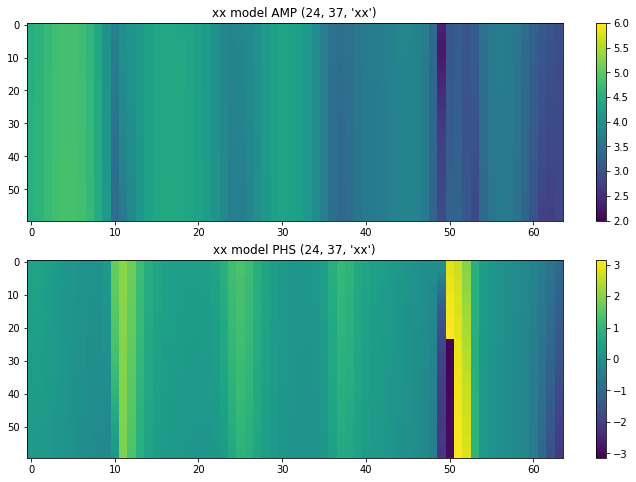

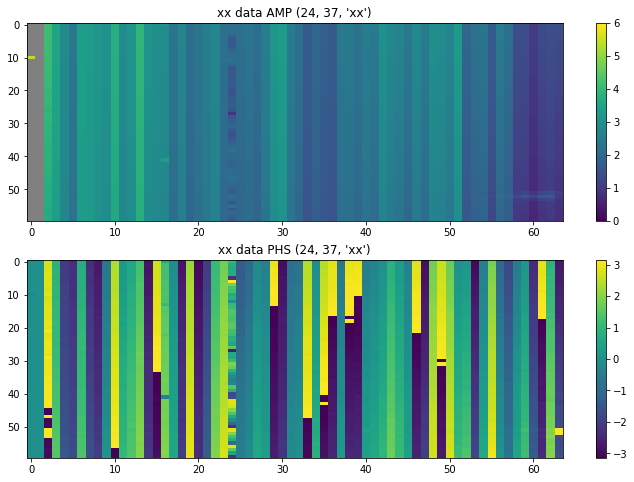

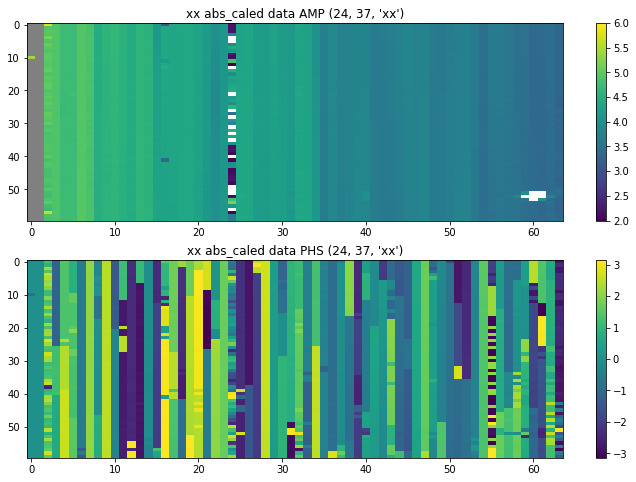

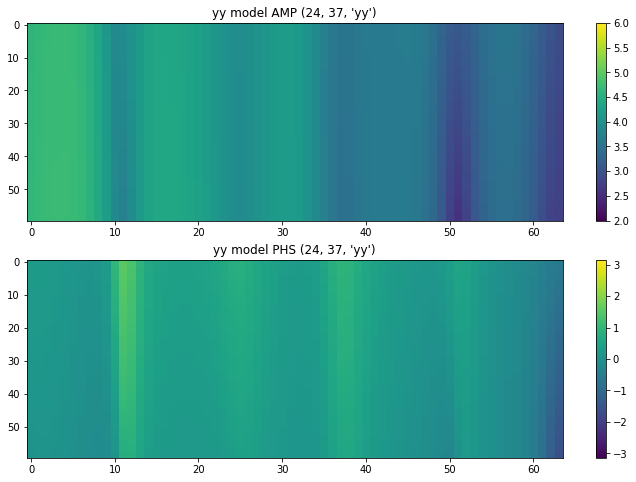

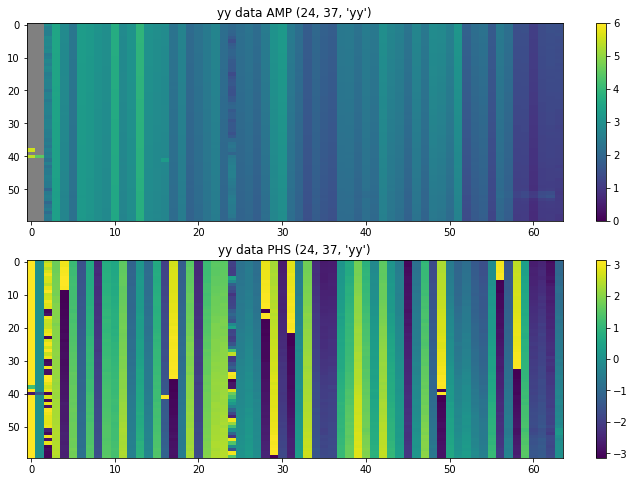

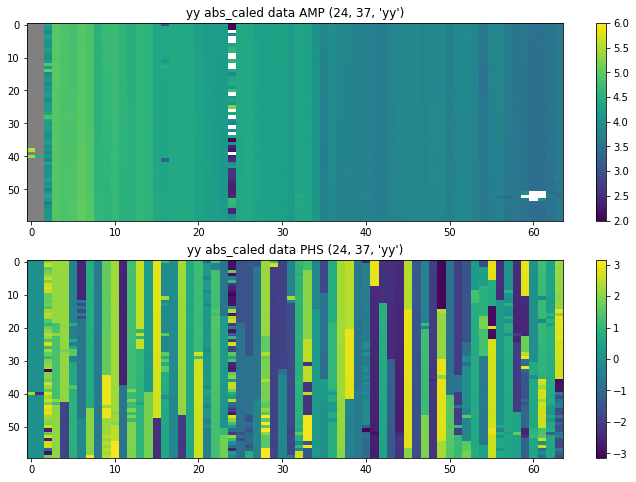

In [97]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [98]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [99]:
#print noise['x']

In [100]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 7328336.000MB


In [101]:
##################### Delete or Erase Data #######################
Erase = False
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [102]:
print Ni

[29.28448607+0.j 21.03562813+0.j  7.8867798 +0.j ... 33.94569374+0.j
 93.76376339+0.j 21.37384051+0.j]


In [103]:
# pre_ampcal = False

In [104]:
#pre_ampcal = True

In [105]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [-0.15999073 -0.09841948] yy [0.02930894 0.05997887]
>>>>>>>>>>>>>additive fitting amp [-0.01976649+0.j -0.01203732+0.j] additive fraction 1.1585392126207894 pre process rephase xx [0.10741962 0.124497  ] yy [-0.05916669  0.15243546]
>>>>>>>>>>>>>additive fitting amp [0.00988633+0.j 0.03051665+0.j] additive fraction 1.2404607349001109 pre process rephase xx [0.00140081 0.00018782] yy [-0.00153795 -0.00297766]
>>>>>>>>>>>>>additive fitting amp [0.00986715+0.j 0.03049385+0.j] additive fraction 0.032777723489148244 pre process rephase xx [0.00143653 0.00030027] yy [-0.00150624 -0.00287571]
>>>>>>>>>>>>>additive fitting amp [0.00985453+0.j 0.03043818+0.j] additive fraction 0.03202478857178607 pre process rephase xx [0.00136601 0.00040135] yy [-0.0014737  -0.00277245]
>>>>>>>>>>>>>additive fitting amp [0.00984965+0.j 0.0303528 +0.j] additive fraction 0.031254174014207325 pre process rephase xx [0.00130492 0.00053669

>>>>>>>>>>>>>additive fitting amp [0.00982604+0.j 0.02303989+0.j] additive fraction 0.02043334648294441 pre process rephase xx [0.00025141 0.00096317] yy [-0.0011398  -0.00028369]
>>>>>>>>>>>>>additive fitting amp [0.00981376+0.j 0.02285927+0.j] additive fraction 0.020810209317484965 pre process rephase xx [0.00022534 0.00099384] yy [-0.00113211 -0.00027396]
>>>>>>>>>>>>>additive fitting amp [0.00980154+0.j 0.02267517+0.j] additive fraction 0.020759047621930225 pre process rephase xx [0.00020526 0.0010258 ] yy [-0.00110944 -0.00025328]
>>>>>>>>>>>>>additive fitting amp [0.0097889 +0.j 0.02249171+0.j] additive fraction 0.020415652119008927 pre process rephase xx [0.00018985 0.00105839] yy [-0.00108836 -0.00023538]
>>>>>>>>>>>>>additive fitting amp [0.00977544+0.j 0.02230849+0.j] additive fraction 0.020109743290243075 pre process rephase xx [0.00017353 0.00109659] yy [-0.00110633 -0.00023168]
>>>>>>>>>>>>>additive fitting amp [0.00976104+0.j 0.02211789+0.j] additive fraction 0.0205337622

>>>>>>>>>>>>>additive fitting amp [0.01056299+0.j 0.01526466+0.j] additive fraction 0.01125663312738691 pre process rephase xx [1.68453248e-03 4.45366457e-05] yy [-0.00019617 -0.00018675]
>>>>>>>>>>>>>additive fitting amp [0.01050185+0.j 0.01518913+0.j] additive fraction 0.010187573172273404 pre process rephase xx [0.00156708 0.00015221] yy [-0.00019521 -0.00018518]
>>>>>>>>>>>>>additive fitting amp [0.01045021+0.j 0.01511402+0.j] additive fraction 0.009660724472251313 pre process rephase xx [0.00139617 0.00033112] yy [-0.00019279 -0.00018116]
>>>>>>>>>>>>>additive fitting amp [0.01041345+0.j 0.01504003+0.j] additive fraction 0.00897834066872315 pre process rephase xx [0.00145148 0.00040401] yy [-0.00018911 -0.00017518]
>>>>>>>>>>>>>additive fitting amp [0.01037671+0.j 0.01496777+0.j] additive fraction 0.009203611804772431 pre process rephase xx [0.00129999 0.00044261] yy [-0.00018538 -0.00016953]
>>>>>>>>>>>>>additive fitting amp [0.0103462 +0.j 0.01489721+0.j] additive fraction 0.008

>>>>>>>>>>>>>additive fitting amp [0.00959336+0.j 0.01275015+0.j] additive fraction 0.008946833515573257 pre process rephase xx [6.60282366e-05 1.59541639e-03] yy [-7.47749259e-05 -2.14726208e-04]
>>>>>>>>>>>>>additive fitting amp [0.00955711+0.j 0.01270072+0.j] additive fraction 0.009155719096196493 pre process rephase xx [8.96179219e-05 1.58693244e-03] yy [-8.96765132e-05 -2.11510931e-04]
>>>>>>>>>>>>>additive fitting amp [0.00951538+0.j 0.01264797+0.j] additive fraction 0.009277748527676023 pre process rephase xx [0.00012375 0.0015945 ] yy [ 1.70655617e-06 -3.67915159e-04]
>>>>>>>>>>>>>additive fitting amp [0.009467  +0.j 0.01259589+0.j] additive fraction 0.009409233580679093 pre process rephase xx [0.00014624 0.0016297 ] yy [-3.48519955e-05 -3.28666120e-04]
>>>>>>>>>>>>>additive fitting amp [0.00941183+0.j 0.01254005+0.j] additive fraction 0.009710650124481161 pre process rephase xx [0.00016175 0.00167236] yy [-6.43336166e-05 -3.02473279e-04]
>>>>>>>>>>>>>additive fitting amp [0.00

>>>>>>>>>>>>>additive fitting amp [0.00957534+0.j 0.00658308+0.j] additive fraction 0.02717848967106358 pre process rephase xx [3.85877754e-05 1.19133078e-04] yy [-0.00074771 -0.00076619]
>>>>>>>>>>>>>additive fitting amp [0.00960372+0.j 0.00631109+0.j] additive fraction 0.02977315381676535 pre process rephase xx [3.04021443e-05 1.01599195e-04] yy [-0.00067504 -0.0008423 ]
>>>>>>>>>>>>>additive fitting amp [0.0096277 +0.j 0.00604752+0.j] additive fraction 0.02911681131353341 pre process rephase xx [1.48600160e-04 1.54299552e-05] yy [-0.00071069 -0.00089469]
>>>>>>>>>>>>>additive fitting amp [0.00964225+0.j 0.00577113+0.j] additive fraction 0.030990457782289555 pre process rephase xx [1.06002811e-04 1.78075111e-05] yy [-0.00078885 -0.00094724]
>>>>>>>>>>>>>additive fitting amp [0.00965405+0.j 0.00547272+0.j] additive fraction 0.03403811036474679 pre process rephase xx [7.58427382e-05 1.84448677e-05] yy [-0.00086515 -0.00101238]
>>>>>>>>>>>>>additive fitting amp [0.0096637 +0.j 0.0051517

>>>>>>>>>>>>>additive fitting amp [0.00971267+0.j 0.00486455+0.j] additive fraction 0.005696839629696372 pre process rephase xx [7.65728405e-09 4.02405839e-08] yy [-0.0001689  -0.00071649]
>>>>>>>>>>>>>additive fitting amp [0.00971268+0.j 0.00481779+0.j] additive fraction 0.00612180386576307 pre process rephase xx [6.51652627e-09 3.42713501e-08] yy [-0.00019222 -0.00060021]
>>>>>>>>>>>>>additive fitting amp [0.00971269+0.j 0.0047662 +0.j] additive fraction 0.006528764761576117 pre process rephase xx [5.54639080e-09 2.91874332e-08] yy [-0.00019865 -0.00050468]
>>>>>>>>>>>>>additive fitting amp [0.00971269+0.j 0.00471378+0.j] additive fraction 0.006545046668244313 pre process rephase xx [4.72116032e-09 2.48575734e-08] yy [-0.00020333 -0.00042466]
>>>>>>>>>>>>>additive fitting amp [0.0097127+0.j 0.0046609+0.j] additive fraction 0.0065508229195335695 pre process rephase xx [4.01905138e-09 2.11699585e-08] yy [-0.00041702 -0.00026527]
>>>>>>>>>>>>>additive fitting amp [0.0097127 +0.j 0.00455

In [106]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

584654.1759615268
2349.5039368520515
490013.22120103094
0.004018621662948082

147.72786410620267
[ 2847.43225479+0.j  2994.67251932+0.j  3241.84804027+0.j ...
 20507.91978909+0.j 21404.0863337 +0.j 20610.59174408+0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905-7.095

In [107]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.009712725728440619+0j) (0.004267359726744857+0j) 2
(0.009712725728440619+0j)
[[0.00971273+0.j]
 [0.00426736+0.j]]
True


In [108]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

584654.1759615268
2349.5039368520515
490013.22120103094
0.838124897329522
147.72786410620267
[0.00276261+0.j 0.00198444+0.j 0.00074402+0.j ... 0.00061816+0.j
 0.00170747+0.j 0.00038923+0.j]
(60.48230968927722+0j)
[19.0256749 +0.j 22.44817982+0.j 36.66139762+0.j ... 40.22058671+0.j
 24.20043824+0.j 50.68733567+0.j]


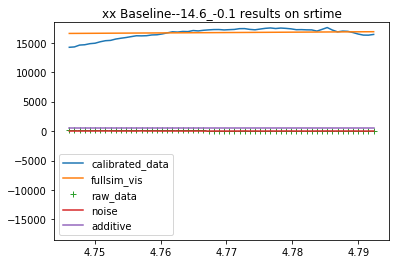

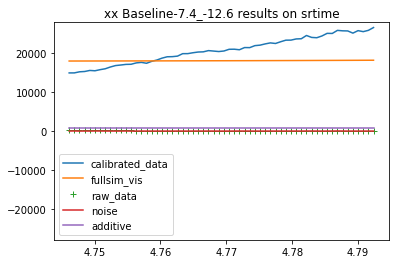

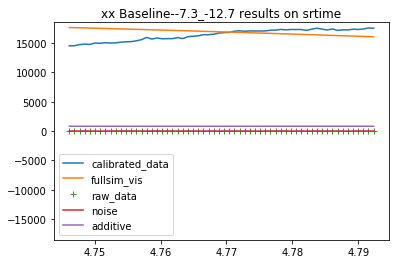

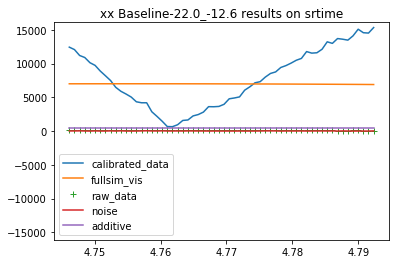

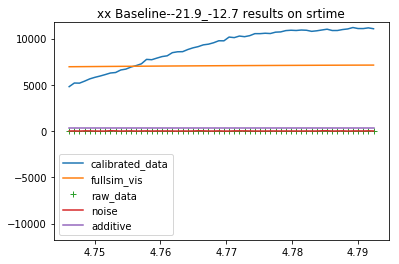

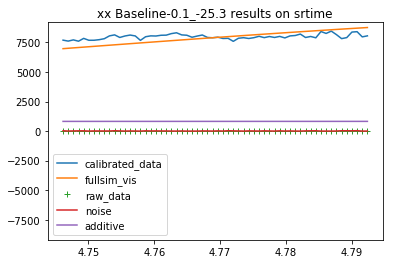

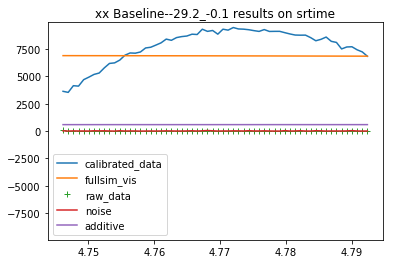

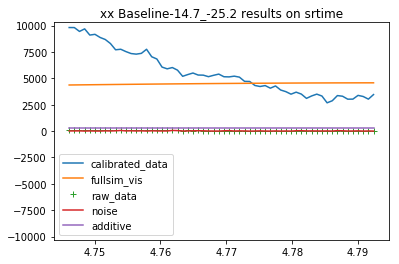

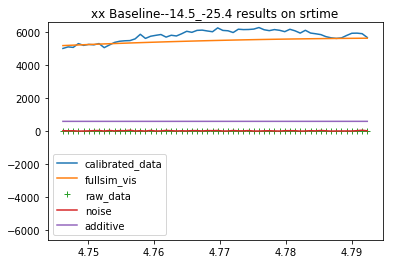

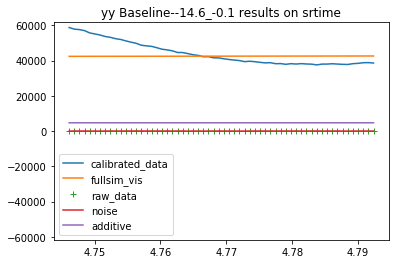

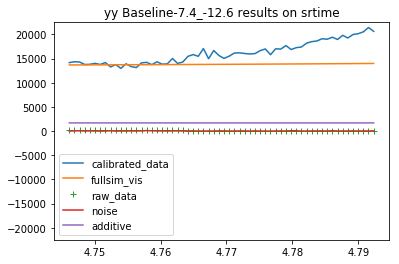

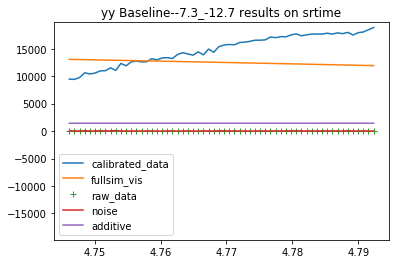

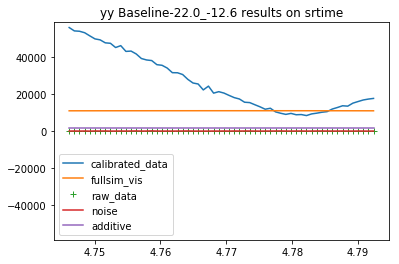

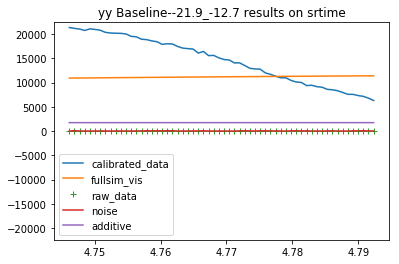

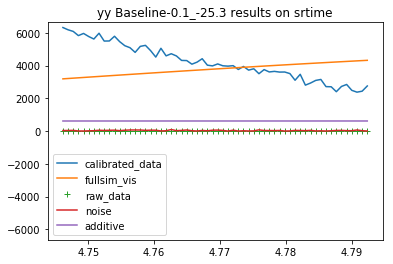

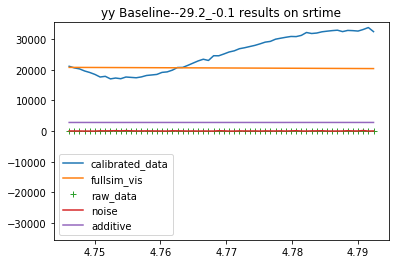

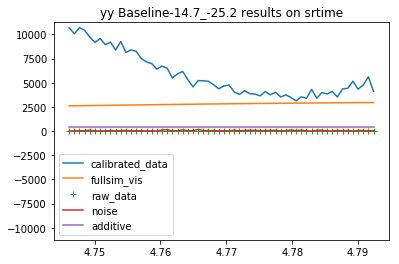

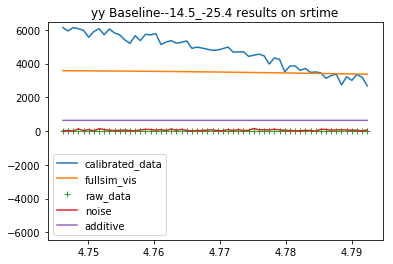

In [109]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [110]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [111]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


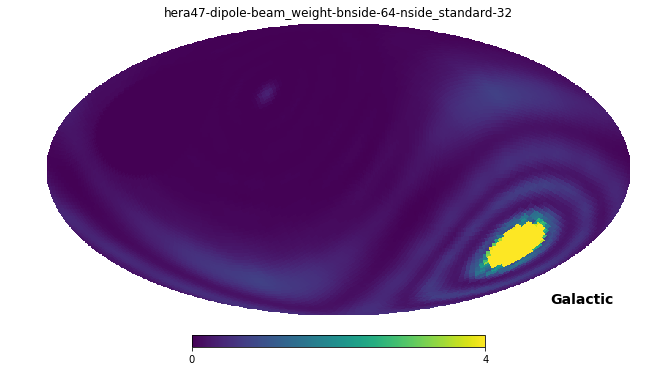

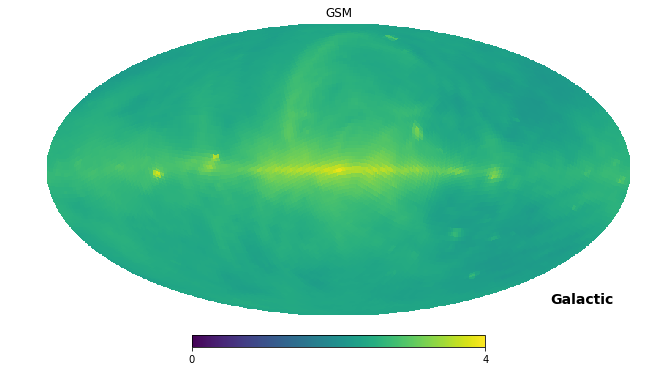

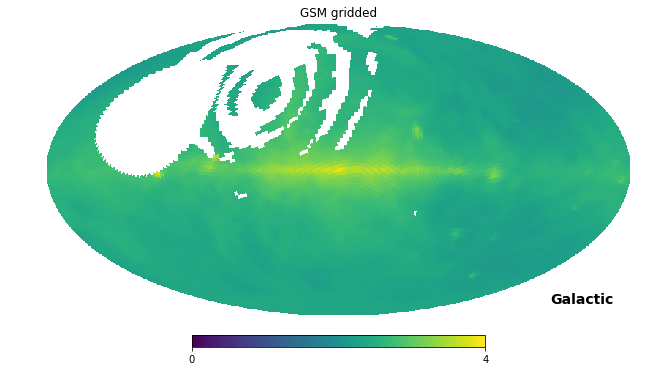

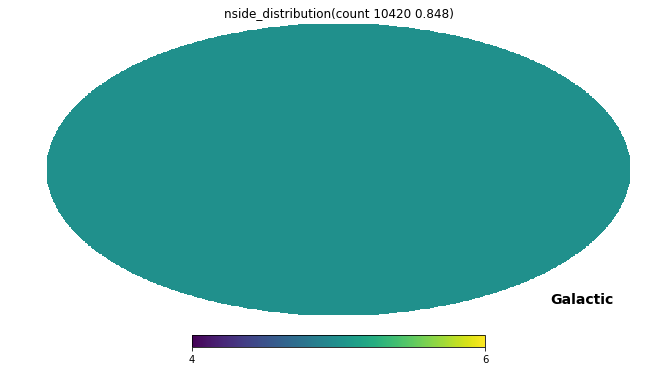

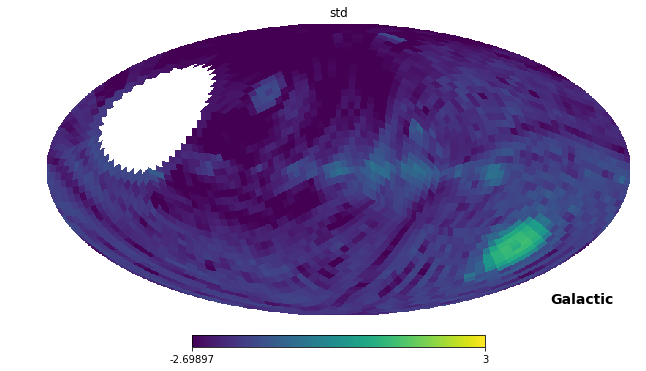

In [112]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

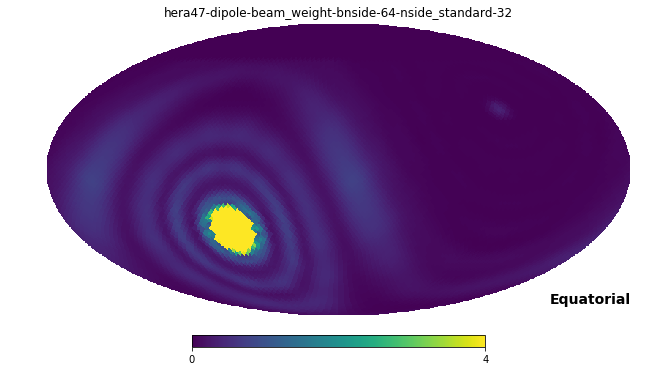

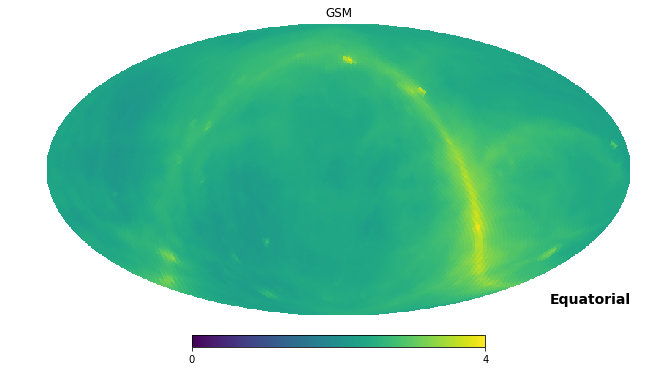

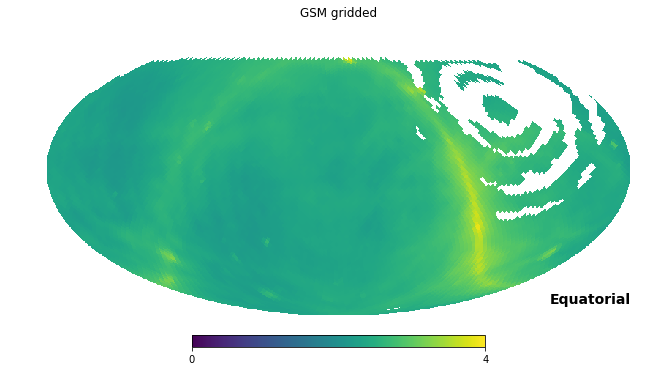

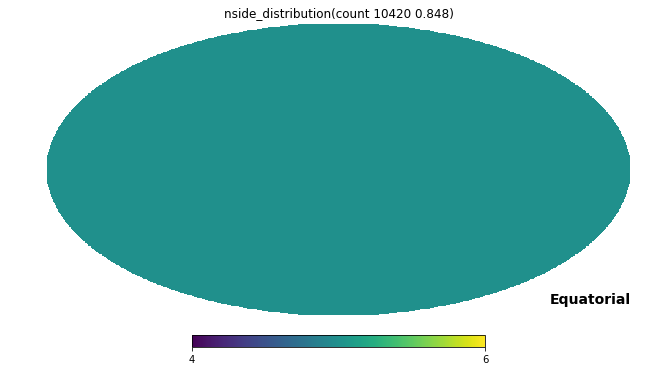

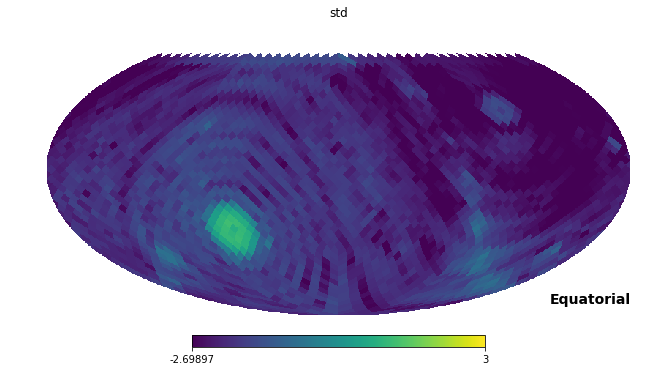

In [113]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [114]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.168099 minutes left

100.0% completed, 0.000072 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [115]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [116]:
Integration_Time
np.sum(Ni**-1)**.5

(1924.721365892801+0j)

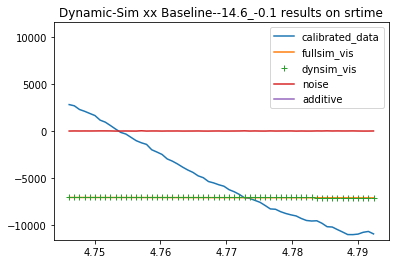

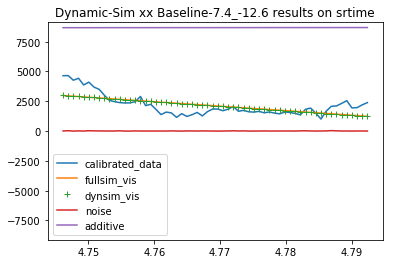

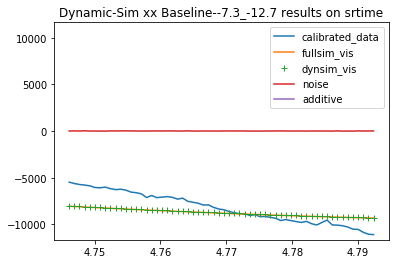

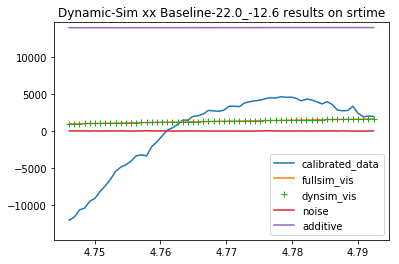

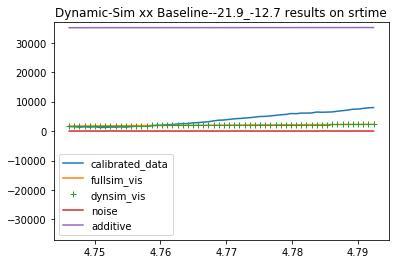

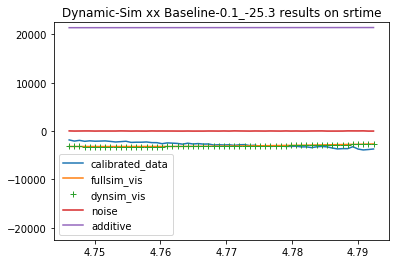

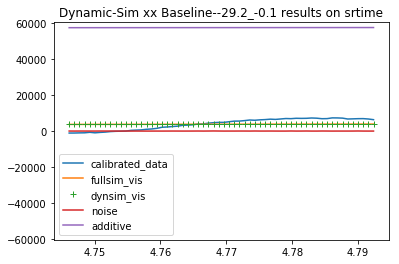

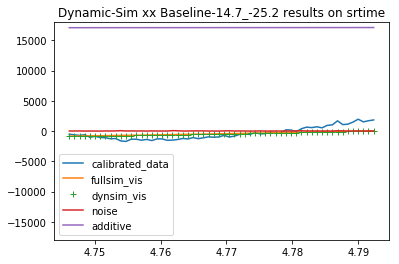

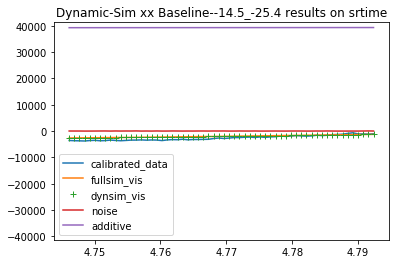

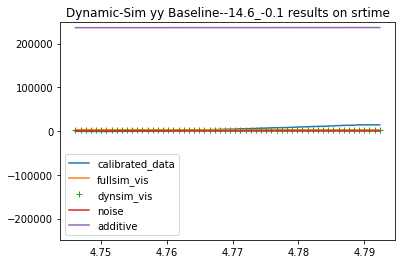

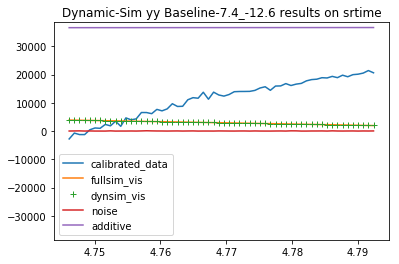

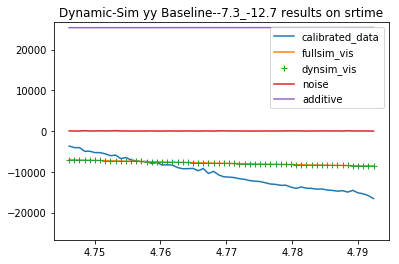

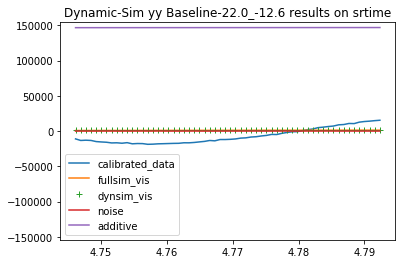

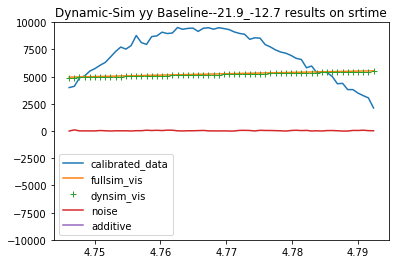

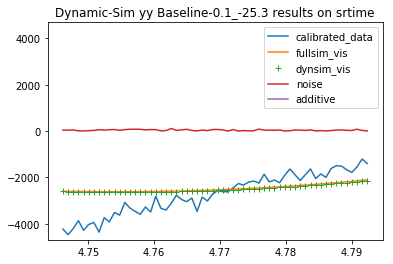

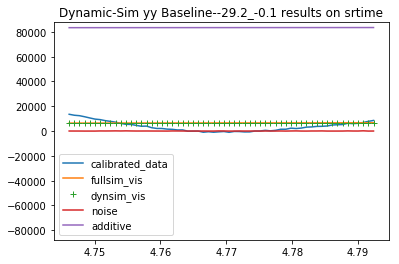

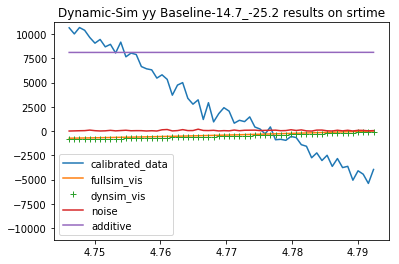

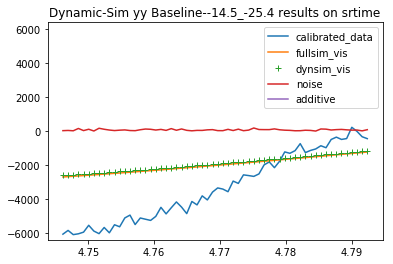

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (1.2590792951413599+0j)


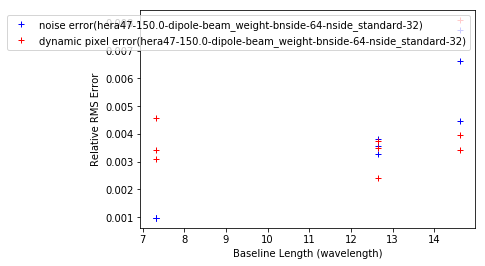

Normalization from visibilities 1.124798395140821


In [117]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [118]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [119]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [120]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000043 minutes used


In [121]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
# rcond_list = 10.**np.arange(-3., -0., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-08 17:47:01.942420
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.0mins 0.569938 minutes used
Computing Regularized AtNiAi, 2018-03-08 17:47:38.253000, expected time 1.0 min trying 1e-07 0.852559 minutes used
regularization stength (0.9909946940822852+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [122]:
S_type
I_supress

1.0

Applying Regularized AtNiAi... Memory usage: 8072605.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../HERA_MapMaking_VisibilitySimulation/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


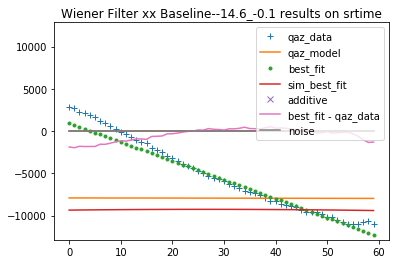

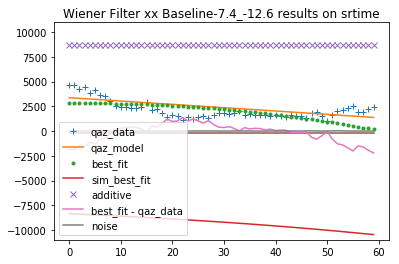

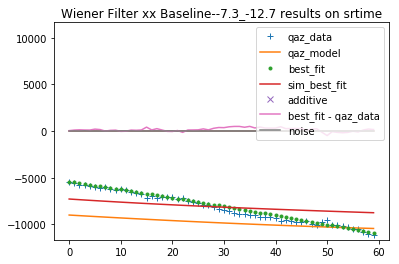

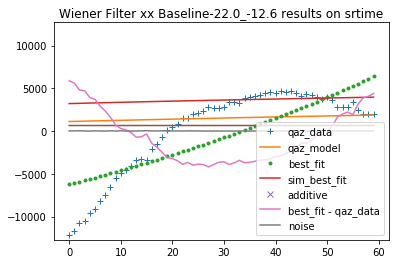

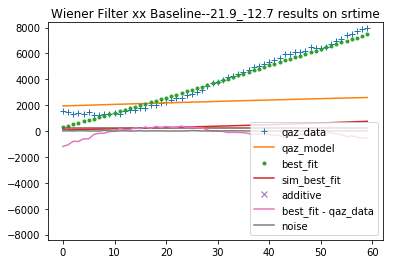

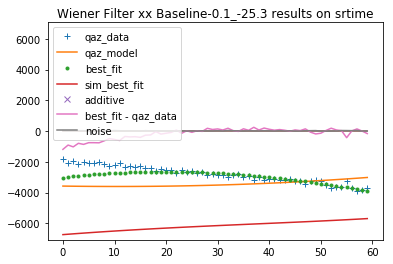

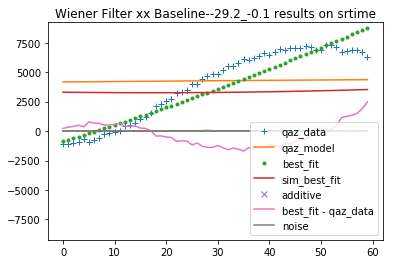

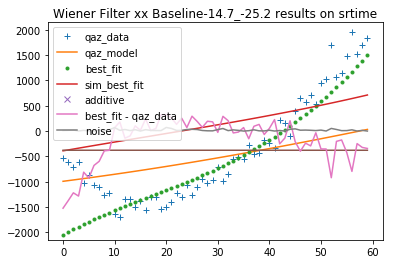

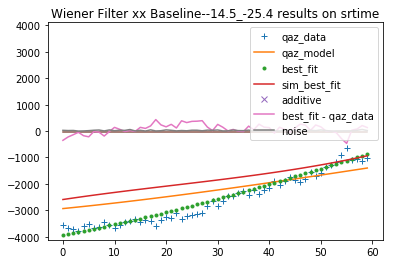

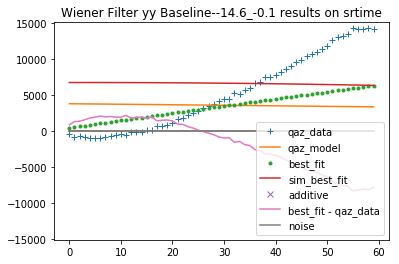

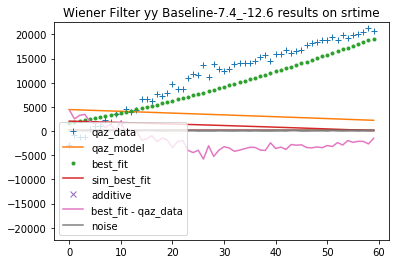

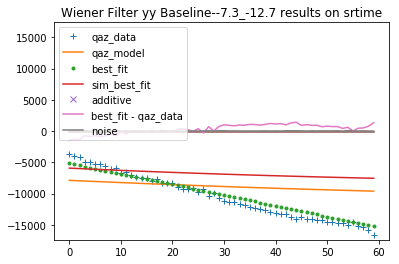

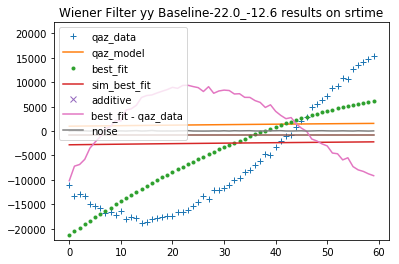

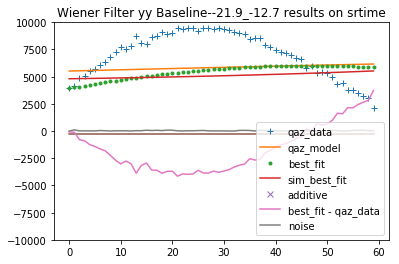

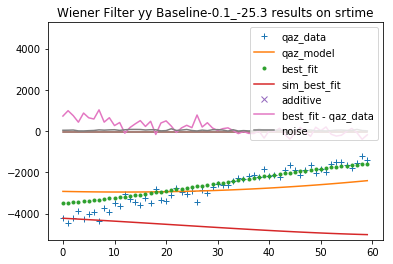

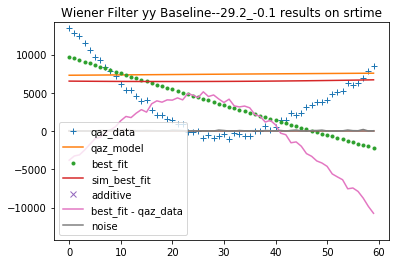

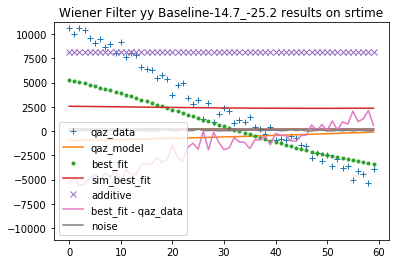

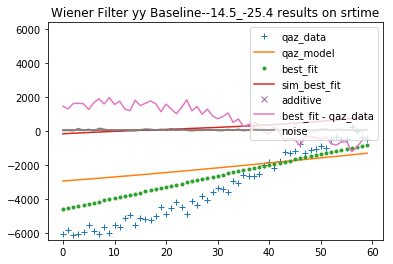

In [123]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [124]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [125]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [126]:
%matplotlib inline

In [127]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5291
Number of Positive w_GSM Pixels: 5677
Number of Positive w_sim Pixels: 5547
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


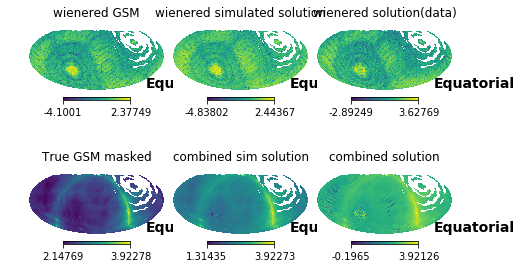

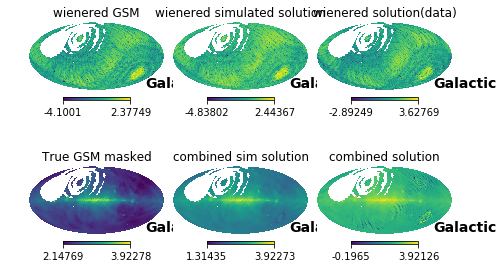

In [128]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


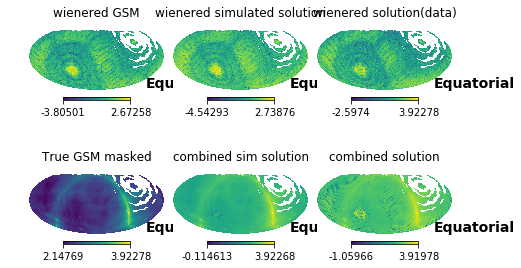

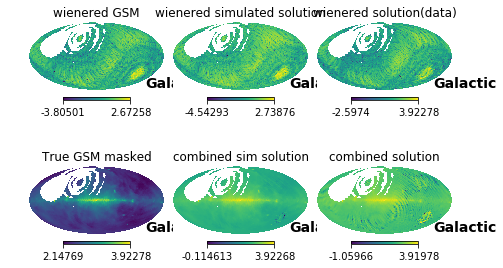

In [129]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


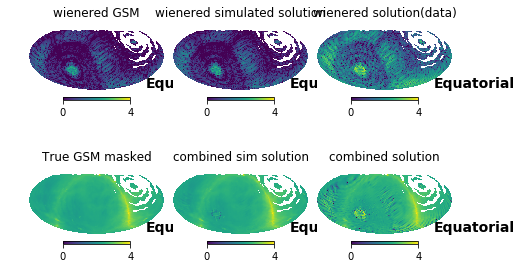

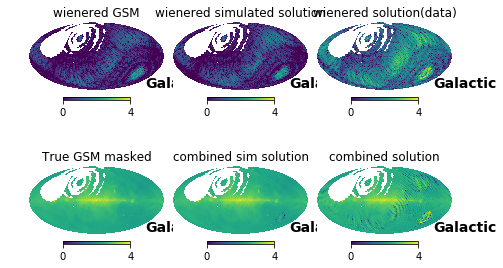

In [130]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


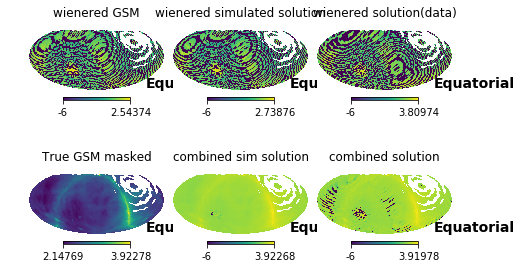

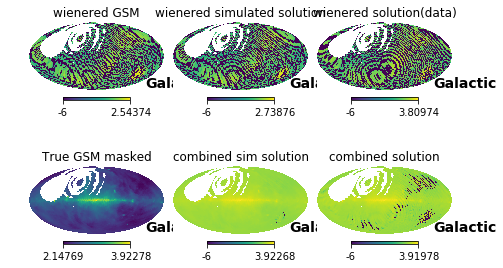

In [131]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


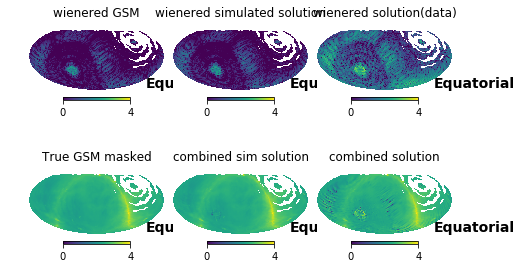

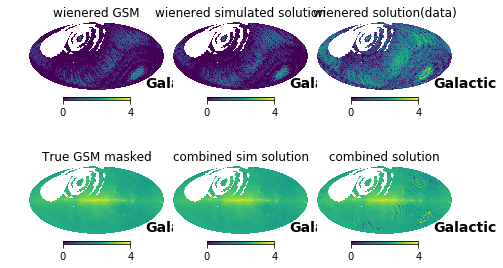

In [132]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


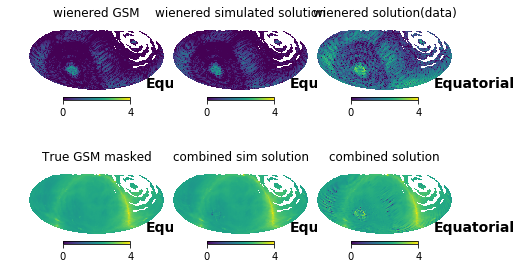

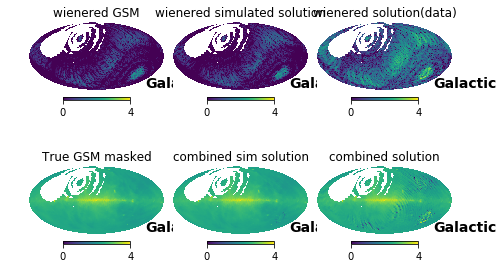

In [133]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 3.210e+08, data points 2160, pixels 10420
re/im chi2 1.660e+08, 1.550e+08
xx/yy chi2 8.363e+07, 2.374e+08


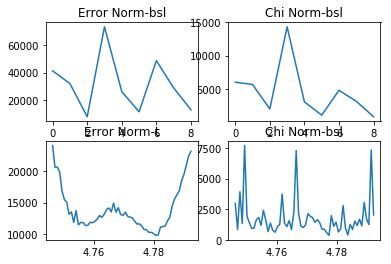

Additive_sol: [0.00971273+0.j 0.00426736+0.j]
('regularization stength', (0.9909946940822852+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 1.972830113910713


In [134]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

In [135]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [136]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 -3.785290652650653e-18


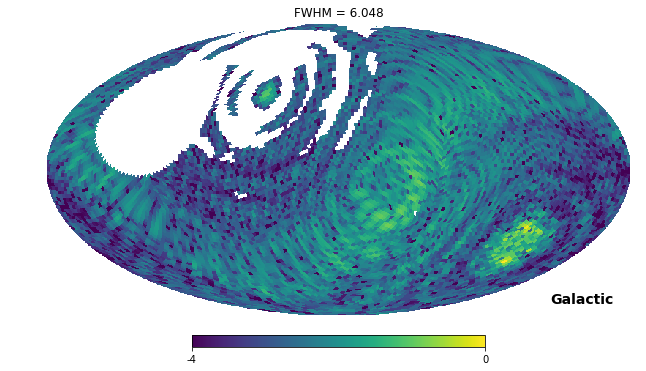

1.5707963267948966 3.5886741904258676e-18


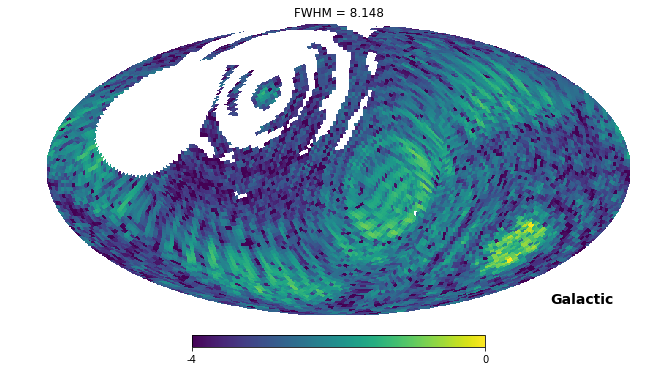

1.5707963267948966 1.0878741944136569e-17


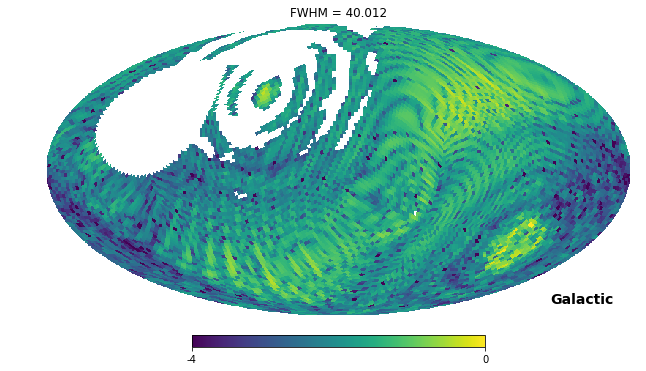

1.5707963267948966 -3.785290652650653e-18


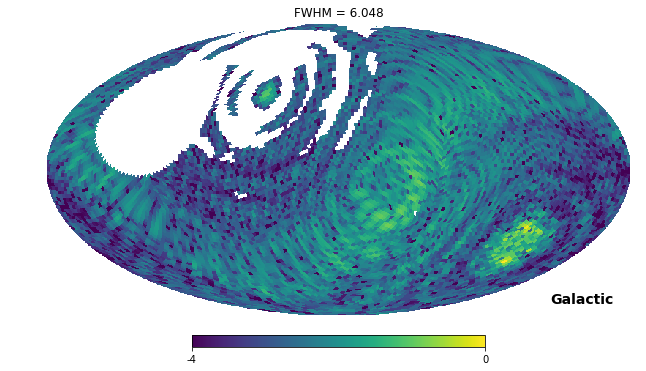

1.5707963267948966 3.1760954804746706e-18


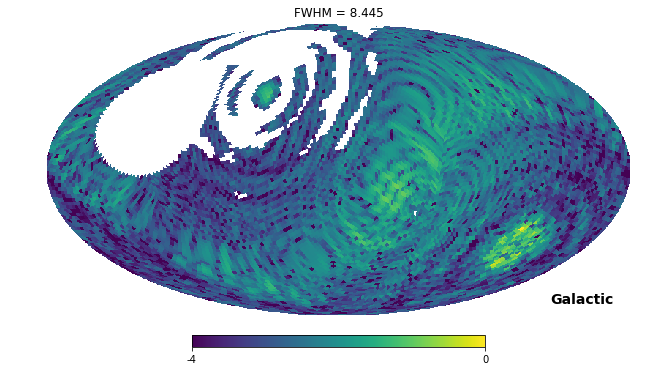

1.5707963267948966 8.000694609459136e-18


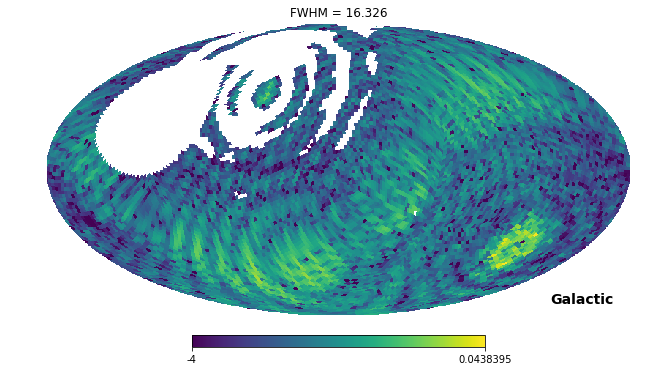

1.5707963267948966 1.0042191136761148e-19


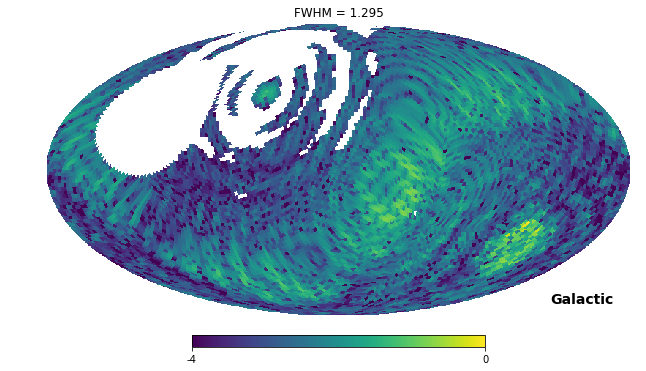

1.5707963267948966 3.702566854876477e-18


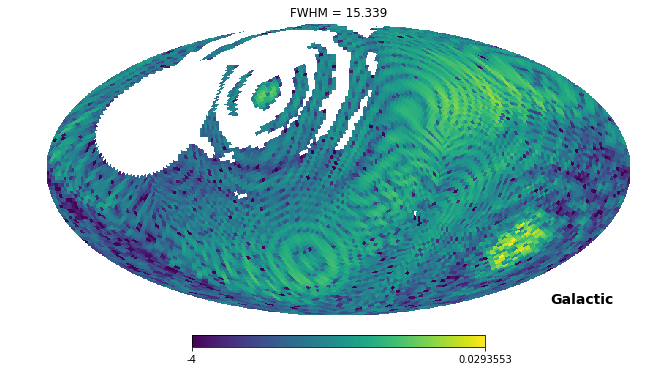

1.5707963267948966 -2.1148506956045332e-17


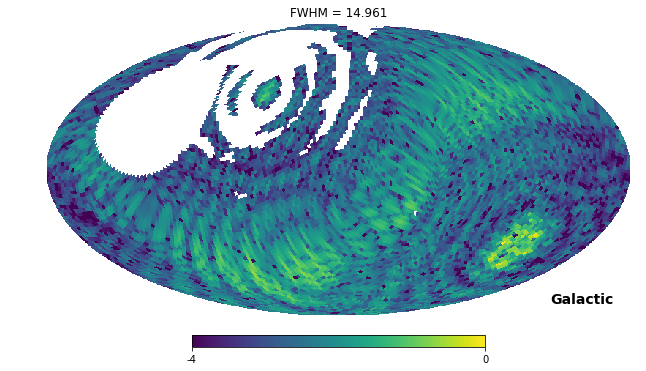

1.5707963267948966 2.8813812411152517e-18


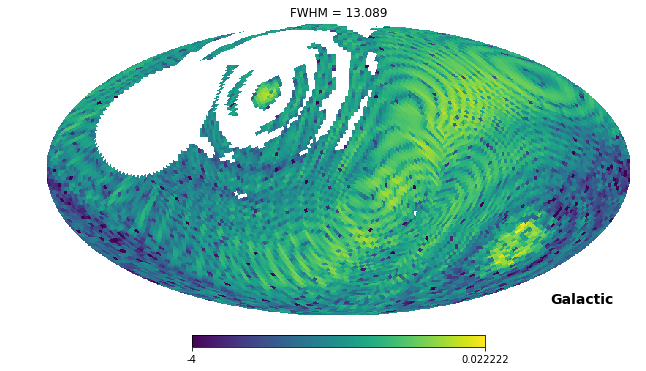

1.5707963267948966 -1.1619343896396845e-17


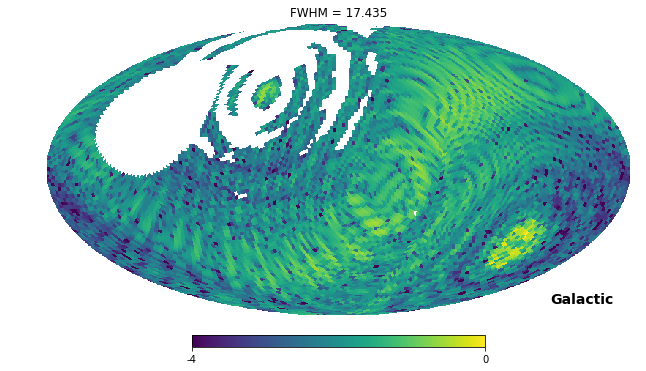

1.5707963267948966 -2.9996614811593564e-17


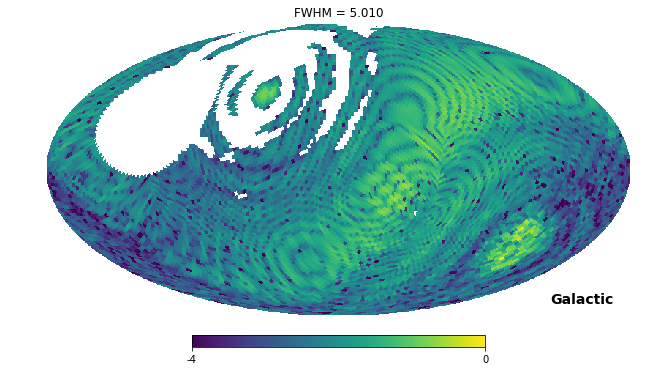

1.5707963267948966 -2.0530449601698684e-18


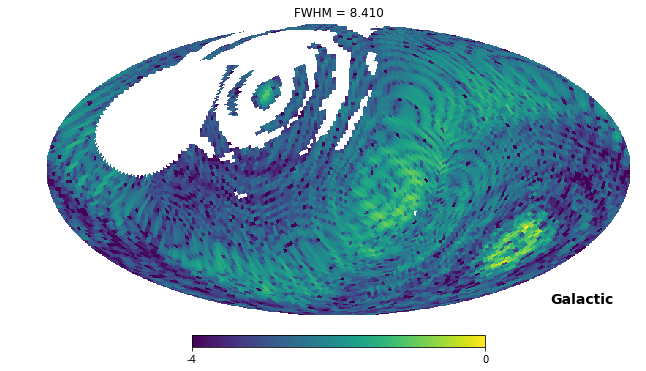

1.5707963267948966 1.0878741944136569e-17


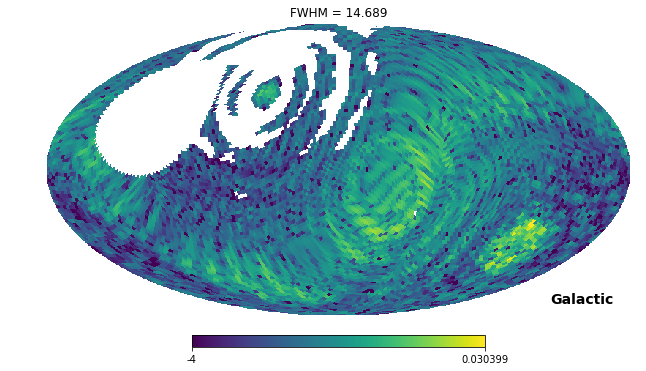

In [137]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [138]:
#point_vec